# <h1><center>Gravitational-Wave Explorer: A Beginner's Guide–Notebook 3 </center><h1>

Authors: Bradlee Tejeda$^{1}$, Rachel Langgin$^{2}$

$^{1}$Las Vegas Academy of the Arts

$^{2}$University of Nevada, Las Vegas

**Goal of Notebook 3**:
In the first two notebooks, we explored what gravitational waves are, how they’re created, how they’re detected, and how to simulate them.

Now, we ask: **what can gravitational waves** tell us about the universe?

In this final notebook, we explore the science of extracting meaning from GW data through:

•	**Bayesian parameter estimation** – figuring out the most likely mass, spin, and distance of the black holes behind a signal.

•	**Population inference** – using many events to understand how black holes form and evolve as a group.

•	How scientists turn signals into stories about the universe’s past.

> This is where gravitational-wave physics becomes gravitational-wave astronomy — where data becomes discovery.

Let’s begin by importing the libraries that will guide us through these deep investigations.

⚠️ Warning: restart the runtime after running the cell below. ⚠️

To do so, click "Runtime" in the menu and choose "Restart and run all".

In [ ]:
# === Install required packages if not already installed ===
import sys
import subprocess

# === Imports ===
import os                                          # Operating system utilities
import requests                                    # For HTTP requests (e.g., downloading images or data)
import numpy as np                                 # Numerical operations
import pandas as pd                                # DataFrames and CSV utilities
import matplotlib.pyplot as plt                    # Plotting
import matplotlib.image as mpimg                   # Image display for matplotlib
from mpl_toolkits.mplot3d import Axes3D            # 3D plotting support
from matplotlib.widgets import Slider              # Interactive sliders for matplotlib
from ipywidgets import interact                    # Jupyter interactive controls
import ipywidgets as widgets                       # Jupyter interactive widgets
from IPython.display import display, HTML, Image, Markdown  # Rich display in Jupyter/Colab

import astropy.constants as const                  # Physical constants for astronomy

from google.colab import files, drive              # Google Colab integration (files and Drive)

# Gravitational wave libraries
!pip install bilby --quiet
!pip install gwpy --quiet
!pip install gwosc --quiet
!pip install pycbc --quiet
!pip install lalsimulation --quiet
import bilby                                       # Bayesian inference for GW
from gwpy.timeseries import TimeSeries             # GW data time series
from gwosc.datasets import event_gps               # Event GPS times from GWOSC

from pycbc.waveform import get_td_waveform         # Generate time-domain waveforms
from pycbc.types import TimeSeries as PTS          # PyCBC time series class

import lalsimulation                               # LIGO Algorithm Library Simulation

# Configure matplotlib for high-res inline plots in Jupyter/Colab
%config InlineBackend.figure_format = 'retina'     # High-DPI plots in notebooks

# Turn on interactive plotting
plt.ion()                                          # Interactive mode for matplotlib plots

ERROR: Could not find a version that satisfies the requirement lalsimulation (from versions: none)
ERROR: No matching distribution found for lalsimulation


/usr/local/lib/python3.12/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


# Probability Review

Probability tells you how likely something is to happen. It’s written as a number between 0 and 1. A probability of 0 means something can’t happen, and a probability of 1 means it will definitely happen. You can also think of it as a percentage between 0% and 100%.

You can figure out a probability by looking at data. For example, suppose you count all the pets in your neighborhood and find that half of them are dogs. Then, the probability of randomly picking a dog is:

$\frac{\text{# of dogs}}{\text{Total # of pets}} = 0.5$ (or $50%$)

This first guess—based just on how many dogs there are in general—is called the **prior probability**. It's what you believe before you have any extra clues or evidence.

In [ ]:
'''Warm-up: Estimating probabilities with pets'''

# Setup: pretend pet data
total_pets = 100      # Total number of pets in this imaginary dataset
dogs = 50             # Out of the 100 pets, 50 are dogs

# Prior probability of being a dog
P_dog = dogs / total_pets   # Calculate the basic (prior) probability of picking a dog at random

# Display the result with two decimal places
print(f"The probability of being a dog given a leash is {P_dog:.2f}")

The probability of being a dog given a leash is 0.50


Let’s say you see a pet, but you don’t know what kind it is. You do notice one thing: the pet has a leash. That’s a clue!

You look at your data again and find out:
- 70% of dogs have leashes.
- Only 40% of all pets (dogs, cats, rabbits, etc.) have leashes.

That’s useful information! You can now update your guess based on this clue.

This is where a formula called **Bayes Theorem** comes in. It helps you calculate the updated probability of something (like being a dog) after seeing some evidence (like having a leash).

Here’s the formula:

$P(\text{Dog} | \text{Leash}) = P(\text{Leash} | \text{Dog}) \times \frac{P(\text{Dog})}{P(\text{Leash})}$

Let’s break that down:
- $P({\rm Dog | Leash})$ means “What’s the chance the pet is a dog, given that it has a leash?”
- $P({\rm Leash | Dog})$ means “If the pet is a dog, what’s the chance it has a leash?” (That’s 70% from your data.)
- $P({\rm Dog})$ is the general chance of a pet being a dog (50% or 0.5).
- $P({\rm Leash})$ is the chance that any pet has a leash (40% or 0.4).

Plug in the numbers and do the calculation using the code cell below:

In [ ]:
'''Warm-up: Estimating probabilities with pets'''

# Setup: pretend pet data
total_pets = 100            # Total number of pets in our imaginary dataset
dogs = 50                   # Number of dogs among the pets
leashed_dogs = 35           # Number of dogs who have leashes
leashed_pets = 40           # Total number of pets with leashes (dogs + others)

# Prior probability of being a dog (P(Dog))
P_dog = dogs / total_pets   # Probability that a randomly chosen pet is a dog

# Likelihood: Probability of having a leash given you're a dog (P(Leash | Dog))
P_leash_given_dog = leashed_dogs / dogs

# Marginal probability of having a leash at all (P(Leash))
P_leash = leashed_pets / total_pets

# Bayes' Theorem to compute posterior: P(Dog | Leash)
P_dog_given_leash = (P_leash_given_dog * P_dog) / P_leash

# Display the result rounded to 2 decimal places
print(f"The probability of being a dog given a leash is {P_dog_given_leash:.3f}")

The probability of being a dog given a leash is 0.875


Even though only half the pets are dogs, once you see that the pet has a leash, the chance it’s a dog jumps up to 87.5%. That’s a much stronger guess!

This is how **Bayes Theorem** helps you make better decisions. You start with what you know (*the prior*), and then update your belief when you get more evidence.

## **Quiz**: Change the numbers and rerun. Can you find a case where the evidence makes no difference?

Now let’s take that same thinking and apply it to one of the coolest areas in modern science: Gravitational Waves (GWs).

GWs are tiny ripples in space caused by big cosmic events—like two black holes crashing into each other. Scientists detect these waves here on Earth using detectors like LIGO and Virgo (see Notebook 2). But detecting the wave is just the beginning. The real mystery is figuring out:
- What objects caused the GW?
- How big are the objects that caused the GW?
- How fast were they spinning?
- How far away were they?

To answer these questions, scientists use probability, just like we did with pets.

In the pet example:
- We wanted to guess the type of pet (dog or not dog).
- We used evidence (seeing a leash).
- We used data to figure out how likely our guess was.

In GW science:

- We want to guess the properties of the source, like the masses of the black holes.
- We use evidence (the shape of the GW signal).
- We use models and data to figure out the most likely values for those properties.

This process is called **Parameter Estimation** (PE).

To get started, let's explore a gravitational-wave signal. We'll revisit a signal you already saw in Notebook 2: GW170817, the first binary neutron star merger ever detected.

Fetched 1 URLs from gwosc.org for [1187008867 .. 1187008897))
Reading data... [Done]


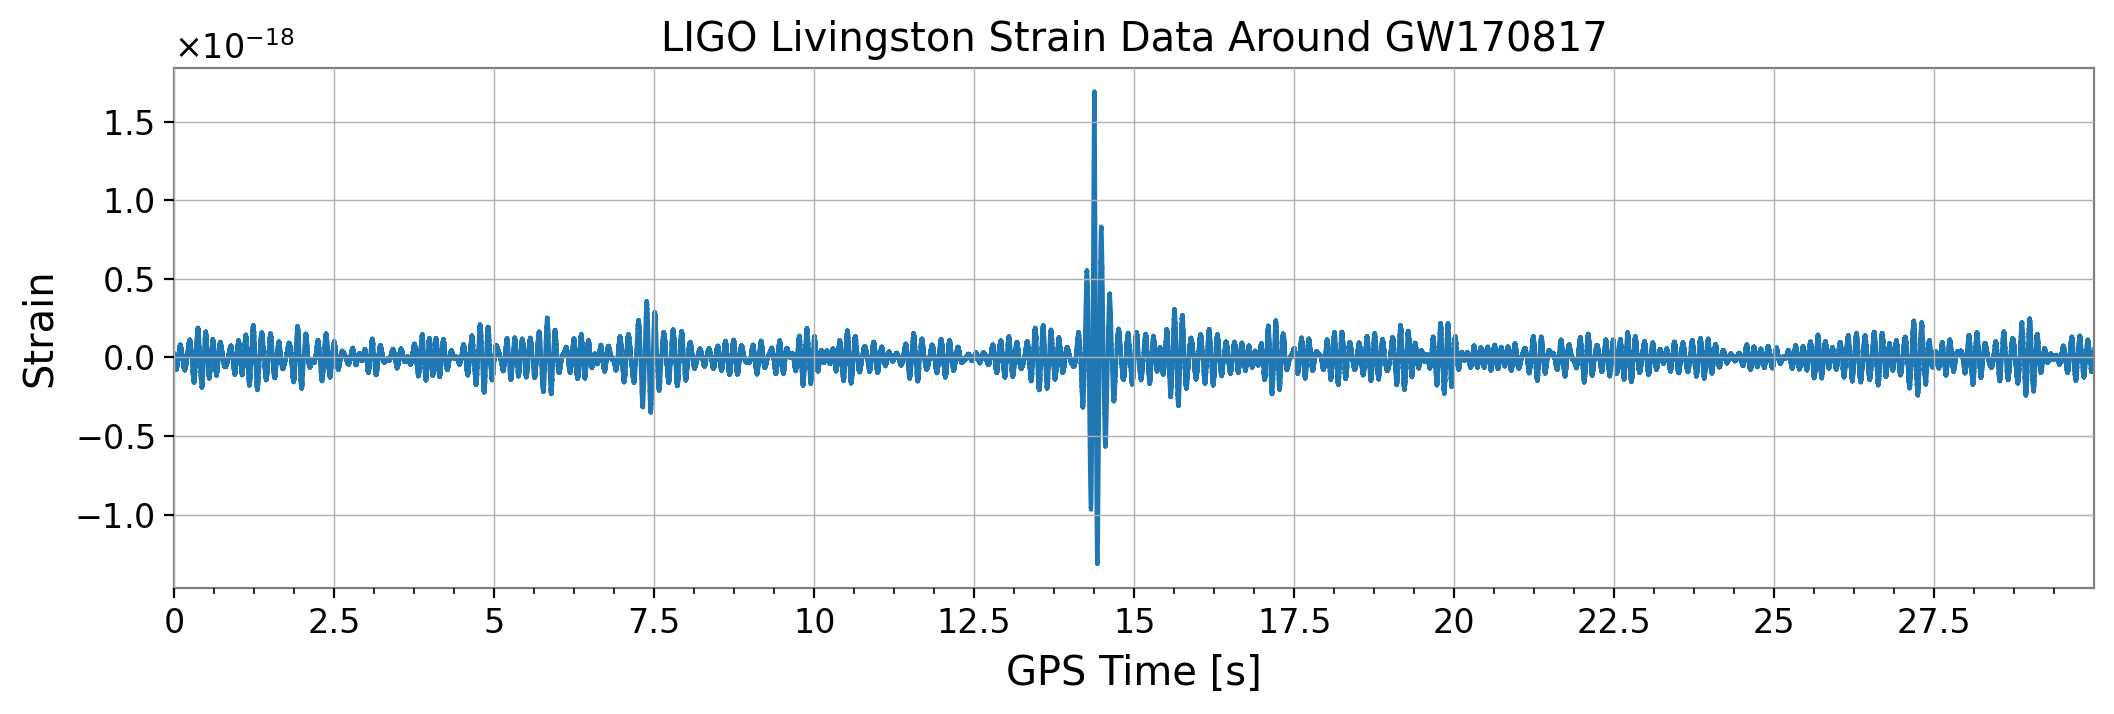

<Figure size 1000x500 with 0 Axes>

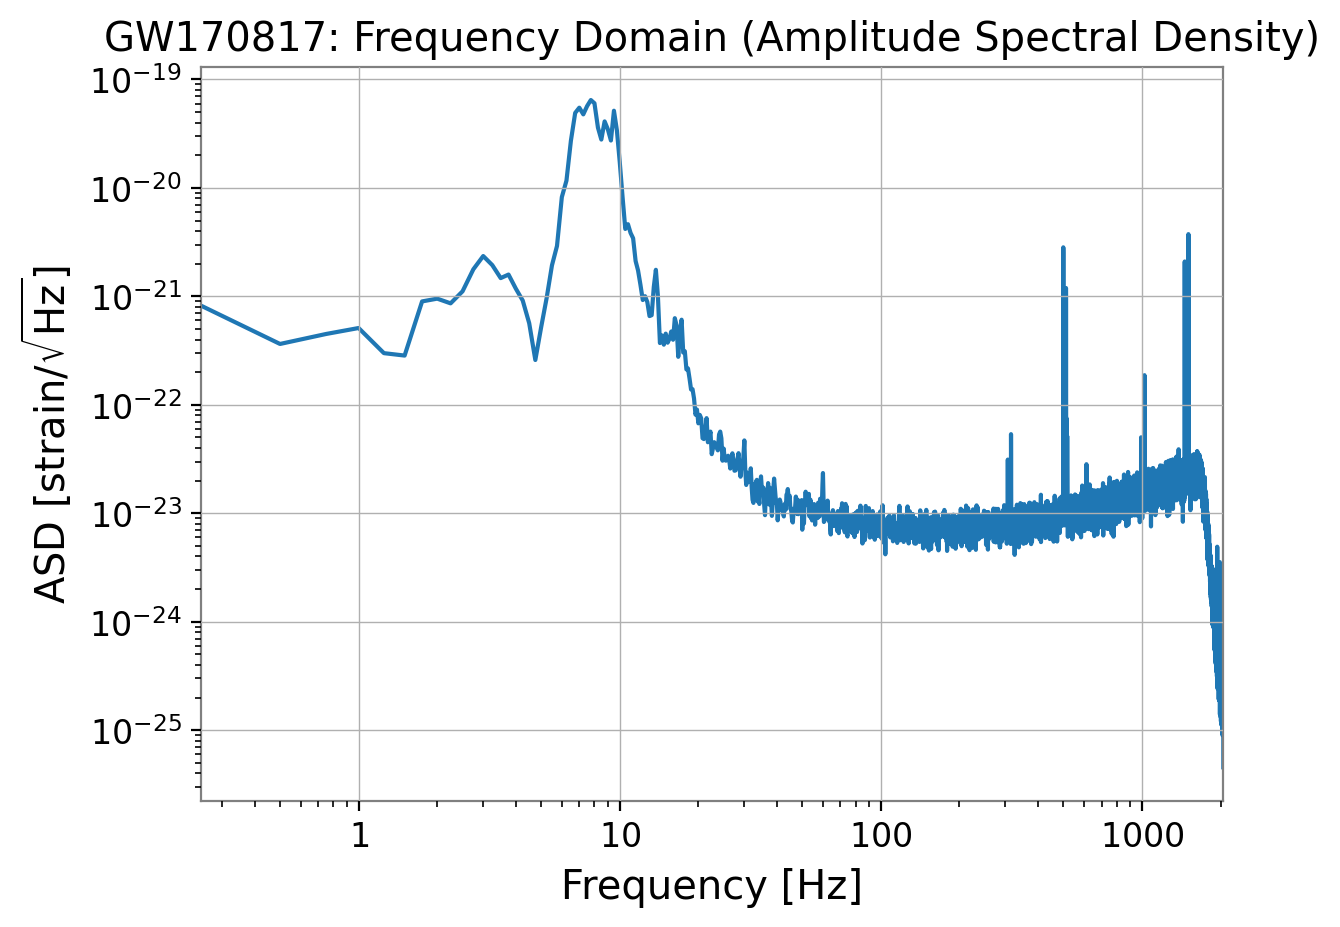

In [ ]:
#### Plot from Notebook 2 is posted here:

# Enable inline plotting so that graphs display directly below each code cell
%matplotlib inline

# Get the GPS time (in seconds) of the GW170817 event (a neutron star merger)
gps_time = event_gps("GW170817")

# Define the time window: 15 seconds before and 15 seconds after the event
start = int(gps_time) - 15
end = int(gps_time) + 15

# Fetch the open strain data from the LIGO Livingston detector (L1) during the defined time window
# 'verbose=True' allows us to see download status and diagnostic output
hdata = TimeSeries.fetch_open_data("L1", start, end, verbose=True)

# Plot the strain data as a function of time
hdata.plot()

# Add a title to the time-domain plot
plt.title("LIGO Livingston Strain Data Around GW170817")

# Label the x-axis as GPS time (in seconds)
plt.xlabel("GPS Time [s]")

# Label the y-axis as strain (dimensionless quantity)
plt.ylabel("Strain")

# Add a grid to the plot to make it easier to read
plt.grid(True)

# Display the time-domain plot
plt.show()

# Compute the Amplitude Spectral Density (ASD) from the strain data
# This shows the signal strength as a function of frequency
asd = hdata.asd(fftlength=4)  # Use a 4-second FFT length to average over the data

# Create a new figure for the frequency-domain (ASD) plot
plt.figure(figsize=(10, 5))

# Plot the ASD curve
asd.plot()

# Add a title to the ASD plot
plt.title("GW170817: Frequency Domain (Amplitude Spectral Density)")

# Label the x-axis as frequency in hertz (Hz)
plt.xlabel("Frequency [Hz]")

# Label the y-axis as ASD in strain per root hertz
plt.ylabel(r"ASD [strain/$\sqrt{\mathrm{Hz}}$]")

# Add a grid to help interpret the frequency plot
plt.grid(True)

# Adjust layout to ensure labels and title fit cleanly
plt.tight_layout()

# Display the frequency-domain plot
plt.show()

When a gravitational wave passes through Earth, it stretches and squeezes space. The shape of this wave—how it rises and falls—is different depending on:
- How heavy the black holes are
- How fast they’re spinning
- How far away they are

That changing signal is like the leash in our pet example. It’s the evidence we use to learn more about the source.

## **Quiz**: Can you point out the chirp signal? What happens to the frequency and amplitude over time?

Let's zoom in on the merger time.

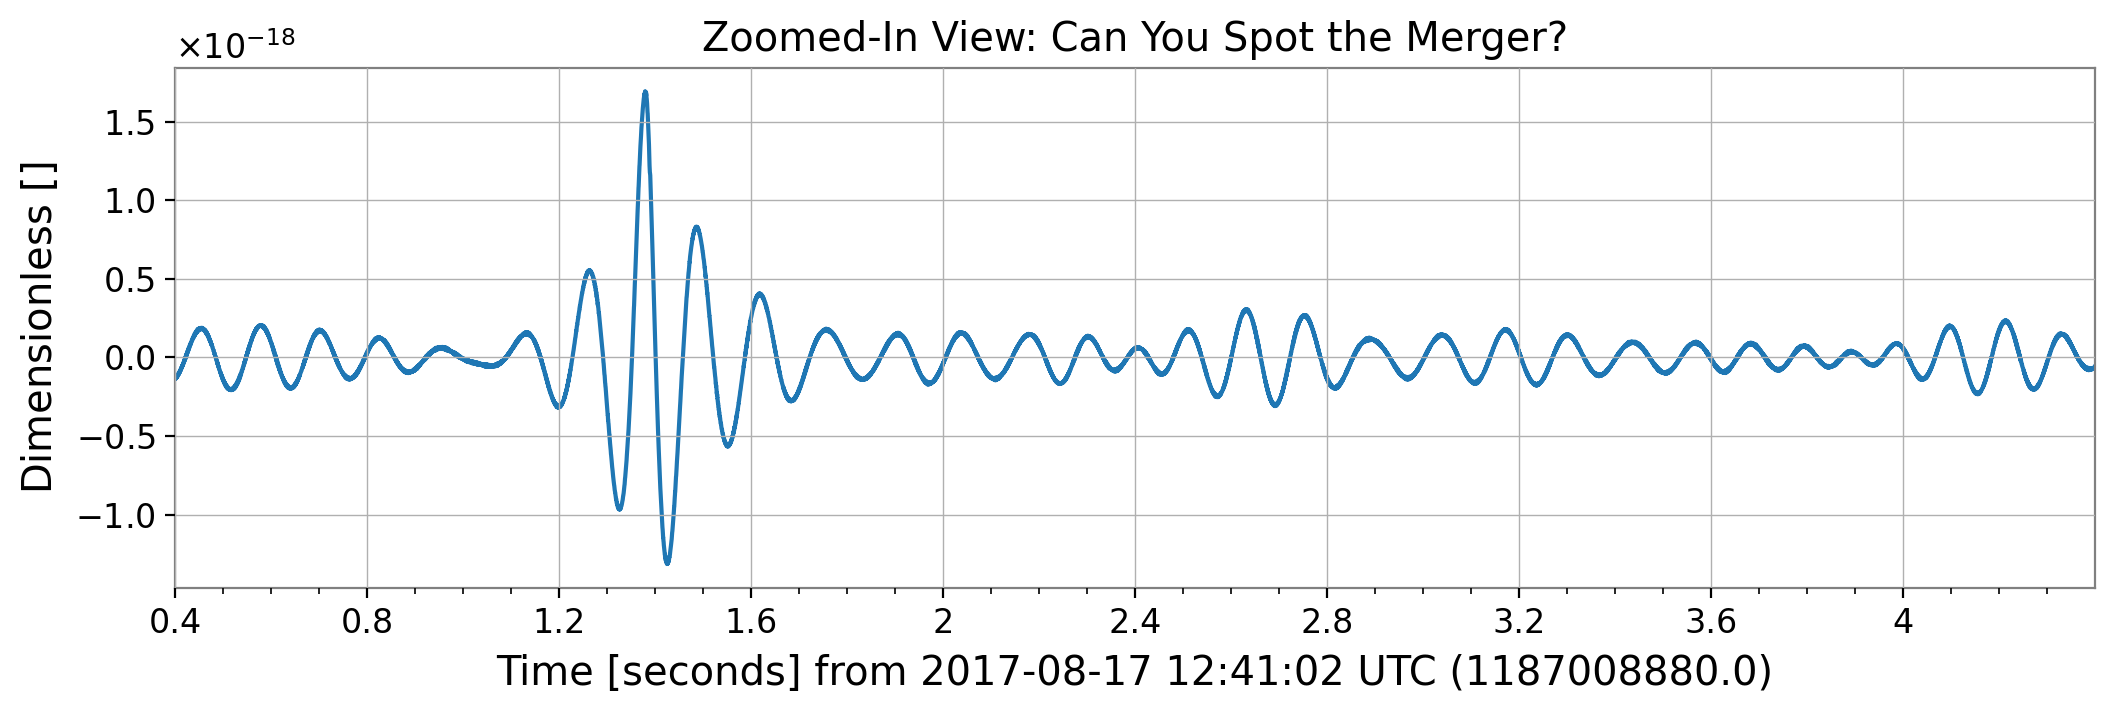

In [ ]:
# Crop the data to a smaller 4-second window centered on the event
zoom = hdata.crop(gps_time - 2, gps_time + 2)

# Plot the zoomed-in data with a custom title
zoom.plot(title="Zoomed-In View: Can You Spot the Merger?")
plt.show()  # Display the plot

## Now let's play a parameter estimation game.

- Generate a few template waveforms for different chirp masses using a simple library, like PyCBC
- Overplot each on the real data
- "Guess" which mass fits best!


In [ ]:
# Define a function to generate a gravitational waveform template
def generate_template(m1, m2):
    # Compute the time-domain waveform using the TaylorT4 approximant
    hp, _ = get_td_waveform(approximant="TaylorT4",
                            mass1=m1, mass2=m2,
                            delta_t=1.0/4096,  # Sampling interval
                            f_lower=30)        # Starting frequency
    return hp  # Return the plus-polarization strain

In [ ]:
def pad_or_trim_waveform(waveform, target_length):
    """
    Crop or pad waveform to match target_length.
    Pads with zeros if waveform is shorter than target_length.
    """
    # If the waveform is longer than the target length, crop it
    if len(waveform) > target_length:
        return waveform[:target_length]
    else:
        # If it's shorter, pad with zeros at the end to reach target length
        return np.pad(waveform, (0, target_length - len(waveform)), 'constant')

In [ ]:
from ipywidgets import interact, FloatSlider

# Sampling settings
sampling_rate = 4096  # Hz sampling rate (number of samples per second)
duration = 2          # seconds to simulate
num_samples = int(sampling_rate * duration)  # total number of samples
times = np.linspace(0, duration, num_samples)  # array of time values for plotting

# True signal parameters
true_mass1 = 1.5 # mass 1 of the true (observed) system
true_mass2 = 1.3 # mass 2 of the true system
true_signal = generate_template(true_mass1, true_mass2)  # generate true waveform
true_signal = pad_or_trim_waveform(true_signal, num_samples)  # match target length

def interactive_guess_plot(guess_mass1=1.2, guess_mass2=1.2): # Start guesses
    """
    Plot the signals with adjustable guess parameters.
    """
    guess_signal = generate_template(guess_mass1, guess_mass2)  # generate guessed waveform
    guess_signal = pad_or_trim_waveform(guess_signal, num_samples)  # match target length

    # Plot the signals
    plt.figure(figsize=(10, 5))  # set figure size
    plt.plot(times, true_signal, label=f'Observed Signal')  # plot true signal
    plt.plot(times, guess_signal, label=f'Guess: {guess_mass1:.2f}+{guess_mass2:.2f} $M_\\odot$', linestyle='--')  # plot guess
    plt.xlabel("Time (s)")  # x-axis label
    plt.ylabel("Strain")  # y-axis label
    plt.title("Compare Observed Signal to Your Guess")  # plot title
    plt.legend()  # add legend
    plt.grid(True)  # show grid
    plt.show()  # display the plot

# Create sliders without latex in description for compatibility
interact(
    interactive_guess_plot,
    guess_mass1=FloatSlider(value=1.2, min=1.0, max=1.5, step=0.01, description='Mass 1 (M_sun)'),
    guess_mass2=FloatSlider(value=1.2, min=1.0, max=1.5, step=0.01, description='Mass 2 (M_sun)')
)

interactive(children=(FloatSlider(value=1.2, description='Mass 1 (M_sun)', max=1.5, min=1.0, step=0.01), Float…

<function __main__.interactive_guess_plot(guess_mass1=1.2, guess_mass2=1.2)>

# We want to know: What is the most likely mass pair, given this data?

We use the same basic idea as before, but now the "thing we're guessing" is the mass of the two neutron stars in the merger plotted above, not a pet’s species.

**Bayes' Theorem** helps us calculate this. The formula is:

$P({\rm Mass | Signal}) = P({\rm Signal | Mass}) \times \frac{P(\text{Mass})}{P(\text{Signal})}$

Let’s break it down:
- $P({\rm Mass | Signal})$: This is what we want to know. Given the gravitational-wave signal, what’s the chance the neutron stars had a particular combination of masses?
- $P({\rm Signal | Mass})$: This is what we model. If the the stars had certain masses, what kind of signal would we expect? Scientists use computer simulations to figure this out.
- $P({\rm Mass})$: This is our prior belief—what we expect before seeing the signal. For example, we might think neutron star masses usually fall between about 1 and 2 times the mass of the Sun.
- $P({\rm Signal})$: This is the overall chance of getting a signal like the one we saw. It helps balance out the calculation.

Just like with pets, we update our beliefs when we get new evidence. A particular pattern in the gravitational-wave signal can make some mass combinations more likely than others. And we don’t have to stop at mass—this same method works for any property or "parameter" we want to estimate from the signal, like spin, distance, or how the stars orbit each other. This process is called "**Parameter Estimation**".

In [ ]:
def toy_likelihood_scaled(real, template):
    """
    Simple toy likelihood scaled for student-friendly output.
    """
    mse = np.mean((real - template)**2)
    # scale by a factor to get numbers around 0–100 or similar
    return 1 / (mse * 1e42 + 1)

# True signal parameters
true_mass1 = 1.5
true_mass2 = 1.3
num_samples = len(times)  # or however long your waveform array should be
true_signal = generate_template(true_mass1, true_mass2)
true_signal = pad_or_trim_waveform(true_signal, num_samples)  # match target length

# Try different mass guesses
mass_guesses = [(1.2, 1.2), (1.5, 1.3), (1.6, 1.6)]  # list of (mass1, mass2) pairs
scores = []  # store computed likelihood scores here

for m1, m2 in mass_guesses:
    temp = generate_template(m1, m2)
    temp = pad_or_trim_waveform(temp, num_samples)  # make sure same length as true_signal
    score = toy_likelihood_scaled(true_signal.numpy(), temp.numpy())  # compute likelihood
    scores.append(score)

# Print results for each mass guess
for (m1, m2), s in zip(mass_guesses, scores):
    print(f"Mass guess {m1}+{m2} has likelihood score {s:.8e}")


Mass guess 1.2+1.2 has likelihood score 6.78056302e-01
Mass guess 1.5+1.3 has likelihood score 1.00000000e+00
Mass guess 1.6+1.6 has likelihood score 2.25670204e-01


Here are the likelihood scores for three different mass guesses:
- 1.2 + 1.2 → 0.67
- 1.5 + 1.3 → 1.00
- 1.6 + 1.6 → 0.22

The likelihood shows how well a guess matches the true signal—higher is better.

In this toy example, 1.5 + 1.3 is the “most likely” mass pair. These numbers are simplified to help us understand the concept: compare guesses to the observed signal, and the best match has the highest score.

Candidate m1 values: [1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23
 1.24 1.25 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35
 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47
 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55 1.56 1.57 1.58 1.59
 1.6 ]
Candidate m2 values: [1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23
 1.24 1.25 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35
 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47
 1.48 1.49 1.5  1.51 1.52 1.53 1.54 1.55 1.56 1.57 1.58 1.59
 1.6 ]


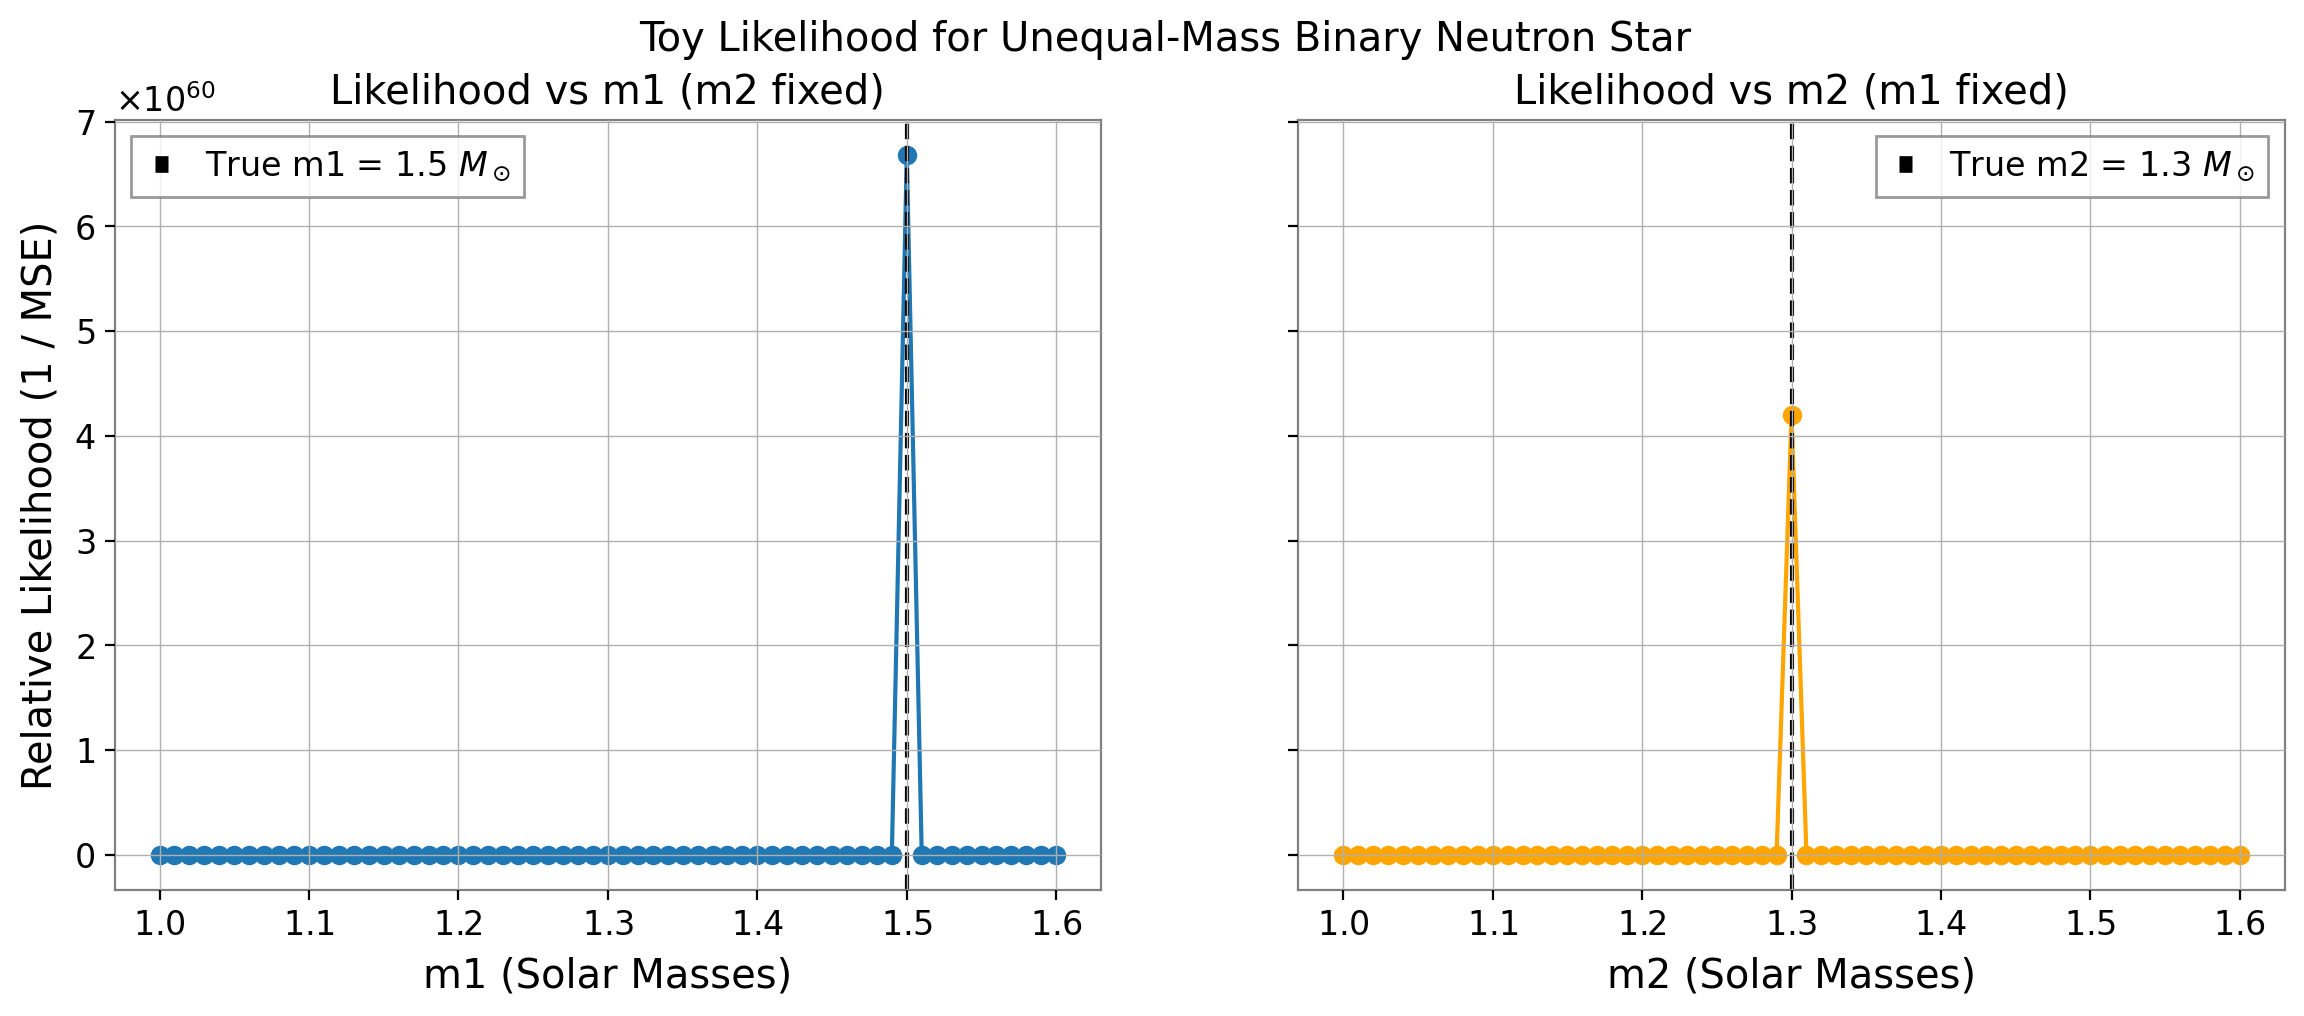

In [ ]:
# Candidate masses for m1 and m2
candidate_m1 = np.arange(1.0, 1.6, 0.01)  # 1.0 to 1.5 in 0.01 steps
candidate_m2 = np.arange(1.0, 1.6, 0.01)

print("Candidate m1 values:", candidate_m1)
print("Candidate m2 values:", candidate_m2)

# Convert true signal to a NumPy array
true_array = np.array(true_signal)

# Lists to hold likelihood scores
scores_m1 = []
scores_m2 = []

# Loop through candidate m1 values (keep m2 fixed at true_mass2)
for m1 in candidate_m1:
    # Generate a waveform for this m1 guess and the true m2
    signal = generate_template(m1, true_mass2)
    # Make sure the waveform has the same number of samples as the true signal
    signal = pad_or_trim_waveform(signal, num_samples)
    # Convert waveform to a NumPy array for easy computation
    signal_array = np.array(signal)
    # Compute mean squared error between guessed waveform and true signal
    mse = np.mean((signal_array - true_array) ** 2)
    # Define a simple toy likelihood as the inverse of MSE
    # If mse is zero (perfect match), set likelihood to infinity
    likelihood = 1 / mse if mse != 0 else np.inf
    # Save the likelihood score for this m1 guess
    scores_m1.append(likelihood)

# Loop through candidate m2 values (keep m1 fixed at true_mass1)
for m2 in candidate_m2:
    # Generate a waveform for the true m1 and this m2 guess
    signal = generate_template(true_mass1, m2)
    # Ensure waveform matches the true signal length
    signal = pad_or_trim_waveform(signal, num_samples)
    # Convert to NumPy array
    signal_array = np.array(signal)
    # Compute mean squared error with the true signal
    mse = np.mean((signal_array - true_array) ** 2)
    # Compute toy likelihood
    likelihood = 1 / mse if mse != 0 else np.inf
    # Store likelihood for this m2 guess
    scores_m2.append(likelihood)

# Plot the results in two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# m1 subplot
axes[0].plot(candidate_m1, scores_m1, marker='o')
axes[0].axvline(x=true_mass1, ls='--', c='black', label=f'True m1 = {true_mass1} $M_\\odot$')
axes[0].set_xlabel("m1 (Solar Masses)")
axes[0].set_ylabel("Relative Likelihood (1 / MSE)")
axes[0].set_title("Likelihood vs m1 (m2 fixed)")
axes[0].legend()
axes[0].grid(True)

# m2 subplot
axes[1].plot(candidate_m2, scores_m2, marker='o', color='orange')
axes[1].axvline(x=true_mass2, ls='--', c='black', label=f'True m2 = {true_mass2} $M_\\odot$')
axes[1].set_xlabel("m2 (Solar Masses)")
axes[1].set_title("Likelihood vs m2 (m1 fixed)")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Toy Likelihood for Unequal-Mass Binary Neutron Star")
plt.show()


The point with the highest likelihood shows the component mass we think is most probable. In this toy example, the recovered masses are close to the true values (1.3 M$_\odot$ for m1 and 1.5 M$_\odot$ for m2).

- After a gravitational-wave detection, scientists typically:
- Run simulations to see what kinds of signals different systems would produce (for example, binary black holes vs. binary neutron stars).
- Compare those simulated signals to the actual observed signal.
- Use Bayes’ Theorem to calculate which properties—like mass, spin, or distance—best explain the data.

In realistic cases, the result isn’t a single number (like “the black hole was 31 solar masses”) but a range of likely values, for example:
- “There’s an 80% chance the black hole’s mass was between 30 and 35 times the mass of the Sun.”

# Practice using Bayesian Parameter Estimation on a real GW Signal:

GWs allow us to study things we can’t see with light. By using Bayesian inference, we can:
- Discover what kinds of black holes are out there
- Learn how they form and evolve
- Test Einstein’s theory of gravity

Let's now go through how to use [Bilby](https://bilby-dev.github.io/bilby/): a user-friendly Bayesian inference library for Gravitational-Wave data with GW170817.


Imagine you’re a gravitational-wave detective. In this part of the code, we inject a fake signal from a binary neutron star system—two stars, each 1.5 and 1.3 times the mass of the Sun—into our data. These “true” values are like the secret identity of the stars, and our job is to see if we can figure them out.

By comparing the injected signal to your guess waveforms, you can watch how tiny changes in mass warp the shape of the wave. This helps build intuition for what real gravitational-wave signals look like in detector data. Scientists do the same thing to make sure their detection tools are accurate and reliable, so when a real cosmic collision happens, we can uncover its hidden properties with confidence.

### Step 1: We are going to inject a binary neutron star dictionary of parameters

We first establish a dictionary of parameters that includes all of the different waveform parameters, including masses of the two neutron stars (mass_1, mass_2), aligned spins of both neutron stars (chi_1, chi_2), etc.


In [ ]:

# Define the injection parameters for the simulated gravitational wave signal
injection_parameters = dict(
    mass_1=1.5,              # Mass of neutron star 1 (solar masses)
    mass_2=1.3,              # Mass of neutron star 2 (solar masses)
    chi_1=0.02,              # Dimensionless spin of neutron star 1
    chi_2=0.02,              # Dimensionless spin of neutron star 2
    luminosity_distance=50.0, # Distance to the source in megaparsecs
    theta_jn=0.4,            # Angle between the total angular momentum and the line of sight
    psi=2.659,               # Polarization angle
    phase=1.3,               # Phase of the waveform at coalescence
    geocent_time=1126259642.413, # GPS time at the Earth's center
    ra=1.375,                # Right Ascension (radians)
    dec=-1.2108,             # Declination (radians)
    lambda_1=545,            # Tidal deformability parameter for neutron star 1
    lambda_2=1346,           # Tidal deformability parameter for neutron star 2
)

### Step 2: Setting up the data segment for analysis

To study the GW170817 signal using the IMRPhenomPv2_NRTidal waveform, we define a 32-second data segment. This length captures the full inspiral and merger while keeping the data manageable. We use a sampling frequency of 2048 Hz, which means the waveform is measured 2048 times per second—enough to resolve the rapid oscillations near the merger.

The segment starts a few seconds before the geocentric merger time (`geocent_time + 2 - duration`) so the signal appears near the end. This placement makes the chirp and coalescence clearly visible, which is helpful for visualization and for injecting the signal into detector data.



In [ ]:
# Step 2: Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the IMRPhenomPv2_NRTidal model:

duration = 32                  # Length of the data segment in seconds
sampling_frequency = 2048      # Samples per second (Hz)
start_time = injection_parameters["geocent_time"] + 2 - duration
# Compute the GPS start time so that the signal is centered near the end of the segment

### Step 3: Defining waveform arguments with IMRPhenomPv2_NRTidal

Next, we set up the waveform using the IMRPhenomPv2_NRTidal model, designed specifically for binary neutron star (BNS) mergers. Think of it as a standard binary black hole waveform (IMRPhenomPv2) that’s been upgraded to include tidal effects—how neutron stars stretch and squeeze each other under extreme gravity as they spiral together.

These tiny deformations leave measurable fingerprints in the gravitational-wave signal. By studying them, scientists can uncover clues about the neutron star equation of state (EoS)—how matter behaves at nuclear densities inside these incredible stars.

For a deeper dive into the model:
Dietrich et al. (2019) – “Improving the NRTidal model for binary neutron star systems”
https://arxiv.org/abs/1804.02235

In [ ]:
# Step 3
waveform_arguments = dict(
    # Specifies the waveform model tailored for binary neutron star mergers,
    # incorporating tidal effects from numerical relativity (NR) simulations
    waveform_approximant="IMRPhenomPv2_NRTidal",

    # Reference frequency (Hz) at which the binary parameters are defined
    reference_frequency=50.0,

    # Minimum frequency (Hz) to include in the waveform, matching detector sensitivity
    minimum_frequency=40.0,
)

### Step 4: Creating the waveform generator with Bilby

Now we build the waveform generator using Bilby, which acts like a toolkit for simulating gravitational-wave signals. It combines the parameters we supply with advanced waveform models from LALSuite, producing realistic signals that detectors would see.

For this example, we focus on binary neutron star mergers. Key settings include:

•	`duration` and `sampling_frequency` which define the time span and resolution of the generated signal,

•	`frequency_domain_source_model` which selects the appropriate LAL function for BNS waveforms,

•	`parameter_conversion` that translates astrophysical parameters into the LALSuite-compatible format,

•	and `waveform_arguments` that fix waveform-specific parameters such as minimum frequency and waveform model choice.
  
With this setup, we can simulate BNS signals accurately, which is essential for both parameter estimation and testing how well our analysis methods work.

In [ ]:
# Step 4
# Create the waveform generator object using Bilby’s interface with LALSuite models
waveform_generator = bilby.gw.WaveformGenerator(
    # Duration of the waveform signal segment in seconds
    duration=duration,

    # Sampling frequency in Hz, defining time resolution of the waveform
    sampling_frequency=sampling_frequency,

    # LALSuite function to generate frequency-domain binary neutron star waveforms
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,

    # Converts user astrophysical parameters into the format expected by LAL functions
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,

    # Fixed waveform model arguments specified above
    waveform_arguments=waveform_arguments,
)

16:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


### Step 5: Assembling the global detective network

In this step, we set up our team of gravitational-wave “detectives” using Bilby’s `InterferometerList`. Each detector has a unique location and perspective:

- H1 is the LIGO detector located in Hanford, Washington
- L1 is the LIGO detector in Livingston, Louisiana
- V1 represents the Virgo detector near Pisa, Italy

Together, they form a global network that can triangulate the source and figure out where in the sky the signal came from.

We set the minimum frequency to 40 Hz, matching the lower sensitivity limit of real detectors. The code then generates realistic noise for each detector and injects our simulated gravitational wave signal into their data streams.

Think of it like a multi-location stakeout: each detector records clues, and by combining them, we can reconstruct the binary merger—just like detectives piecing together evidence to solve a case!

In [ ]:
# Step 5: Set up three interferometers: LIGO Hanford (H1), LIGO Livingston (L1), and Virgo (V1)
# These detectors simulate the gravitational wave data at their design sensitivity
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])

# Set the minimum frequency for each interferometer to 40 Hz (start of analysis range)
for interferometer in interferometers:
    interferometer.minimum_frequency = 40

# Generate synthetic strain data (noise) for each interferometer using power spectral densities
# sampling_frequency: how many samples per second
# duration: length of data segment in seconds
# start_time: GPS time marking the start of the segment
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)

# Inject the simulated gravitational wave signal into the strain data for all interferometers
# using the specified injection parameters and waveform generator
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

16:24 bilby INFO    : Injected signal in H1:
16:24 bilby INFO    :   optimal SNR = 34.44
16:24 bilby INFO    :   matched filter SNR = 34.05-0.36j
16:24 bilby INFO    :   mass_1 = 1.5
16:24 bilby INFO    :   mass_2 = 1.3
16:24 bilby INFO    :   chi_1 = 0.02
16:24 bilby INFO    :   chi_2 = 0.02
16:24 bilby INFO    :   luminosity_distance = 50.0
16:24 bilby INFO    :   theta_jn = 0.4
16:24 bilby INFO    :   psi = 2.659
16:24 bilby INFO    :   phase = 1.3
16:24 bilby INFO    :   geocent_time = 1126259642.413
16:24 bilby INFO    :   ra = 1.375
16:24 bilby INFO    :   dec = -1.2108
16:24 bilby INFO    :   lambda_1 = 545
16:24 bilby INFO    :   lambda_2 = 1346
16:24 bilby INFO    : Injected signal in L1:
16:24 bilby INFO    :   optimal SNR = 27.88
16:24 bilby INFO    :   matched filter SNR = 26.49+3.22j
16:24 bilby INFO    :   mass_1 = 1.5
16:24 bilby INFO    :   mass_2 = 1.3
16:24 bilby INFO    :   chi_1 = 0.02
16:24 bilby INFO    :   chi_2 = 0.02
16:24 bilby INFO    :   luminosity_distance 

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j,
         -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j,
         7.94402485e-26+4.21585695e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.23008636e-25+7.98210938e-26j,
         -4.23011798e-25+7.97089719e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.95519924e-26+4.21582544e-25j,
         7.94402485e-26+4

### Step 6: Setting the prior
Next, we define a prior, which is like laying out the clues we already know before investigating. Here, we fix most parameters—everything except a few key unknowns:

- Chirp mass and mass ratio – the same quantities we explored in Notebook 2, which tell us about the combination of masses in the binary.
- Phase – the orientation of the waveform when it reaches Earth.
- Geocentric merger time – the exact moment the stars collide as measured at Earth’s center.

By fixing the rest and letting these parameters vary, we focus the “investigation” on the most important aspects that determine the shape and timing of the gravitational-wave signal.

In [ ]:
# Step 6: Load the default prior distributions for binary neutron star (BNS) parameters
# Using chirp_mass, symmetric_mass_ratio, lambda_tilde, and delta_lambda_tilde
# instead of individual masses and tidal deformabilities for sampling

priors = bilby.gw.prior.BNSPriorDict()

# Set priors for extrinsic and spin parameters from the injection parameters
for key in [
    "psi",              # polarization angle
    "geocent_time",     # GPS time of event
    "ra",               # right ascension of source
    "dec",              # declination of source
    "chi_1",            # spin of first neutron star
    "chi_2",            # spin of second neutron star
    "theta_jn",         # angle between total angular momentum and line of sight
    "luminosity_distance", # distance to the source
    "phase",            # phase of the waveform at geocent_time
]:
    priors[key] = injection_parameters[key]  # Fix these parameters to injection values

# Remove priors on mass_ratio and individual tidal deformabilities since we sample
# in transformed parameters
del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]

# Define prior on chirp_mass as a Gaussian centered at 1.215 solar masses with std 0.1
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\odot}$"
)

# Define uniform prior on symmetric_mass_ratio between 0.1 and 0.25 (physically motivated range)
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
    0.1, 0.25, name="symmetric_mass_ratio"
)

# Define uniform priors on combined tidal deformability parameters
priors["lambda_tilde"] = bilby.core.prior.Uniform(0, 5000, name="lambda_tilde")
priors["delta_lambda_tilde"] = bilby.core.prior.Uniform(
    -500, 1000, name="delta_lambda_tilde"
)

# Add constraints on individual tidal deformabilities (lambda_1, lambda_2) between 0 and 10000
priors["lambda_1"] = bilby.core.prior.Constraint(
    name="lambda_1", minimum=0, maximum=10000
)
priors["lambda_2"] = bilby.core.prior.Constraint(
    name="lambda_2", minimum=0, maximum=10000
)

<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-867427209.py:27: SyntaxWarning: invalid escape sequence '\o'
  1.215, 0.1, name="chirp_mass", unit="$M_{\odot}$"
16:24 bilby INFO    : No prior given, using default BNS priors in /usr/local/lib/python3.12/dist-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


### Step 7: Using Bayesian inference to solve the case

Bayesian inference is like a detective updating their hunches as new clues come in. It lets us estimate the probability of unknown parameters (like the masses or spins of merging stars) based on the data we observe. We start with prior beliefs—our initial guesses—and then update them with new evidence from the measurements to get the posterior probability, which tells us what’s most likely.

A key tool is the likelihood function, which measures how well a set of parameters explains the observed data. Mathematically, the likelihood $\mathcal{L}$ is expressed as:

$$\mathcal{L}(\text{data} \mid \theta) = p(\text{data} \mid \theta)$$

where $\theta$ represents the parameters of the system, and the likelihood tells us the probability of observing the detector strain data assuming a gravitational-wave signal with those parameters exists, along with the detector noise.

The `bilby.gw.GravitationalWaveTransient` likelihood object acts like a forensic expert. It compares the expected waveform for a given set of parameters to the actual measured data across all detectors, assuming Gaussian, stationary noise. This allows us to rigorously estimate properties of astrophysical sources, like binary neutron star or black hole mergers, based on the evidence in the data.


In [ ]:
# Step 7: Initialize the likelihood object for gravitational wave analysis
# Pass in the interferometer data and the waveform generator to model the expected signals
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,     # List of interferometers with strain data
    waveform_generator=waveform_generator,  # Waveform model generator for signal templates
)

In [ ]:
# This will stop any "Run all" actions before attempting to run the bilby result:
raise SystemExit("Stopping execution here. Run subsequent cells manually.")

SystemExit: Stopping execution here. Run subsequent cells manually.

### Step 8: Connecting to Google Drive
In this step, we mount your Google Drive inside the Colab notebook, which is like giving your workspace access to a shared filing cabinet. This lets you read and save files just as if they were on your own computer

In [ ]:
# Step 8: This block helps us connect Google Colab to our Google Drive.
# That way, we can open files, save our work, and access folders—just like on your computer.

# This part is necessary when you're using files stored on your Drive (like data or sounds).
# Think of it like "plugging in" your Drive to Colab.

from google.colab import drive

# This line mounts (connects) your Google Drive to the notebook.
# You only need to run it ONCE per session. After that, your files will be available in the sidebar on the left.
drive.mount("/content/drive")  # Make sure this is only run once per session

Mounted at /content/drive


### Step 9: Run the analysis! (estimated average runtime ~10 hours) Or read in the results file after the following cell.

In [ ]:
# Replace the outdir with the filepath to an empty folder within your Google Drive
outdir = '/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result'  # Directory to save results
label = 'GW170817'         # Label for this analysis run

# Step 10: Run the sampler to perform Bayesian inference on the signal parameters
result = bilby.run_sampler(
    likelihood=likelihood,                  # Likelihood function defined earlier
    priors=priors,                         # Prior distributions on parameters
    sampler="dynesty",                     # Sampling algorithm (nested sampling)
    npoints=100,                           # Number of points to start with (may be ignored by dynesty)
    injection_parameters=injection_parameters,  # True signal parameters for reference
    outdir=outdir,                        # Output directory for results and plots
    label=label,                         # Label used in output files
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,  # Converts sampled params
    sample="unif",                       # Sampling method (uniform prior)
    nlive=500,                          # Number of live points controlling sampler accuracy
    dlogz=3                             # Stopping criterion for nested sampling evidence precision
)

### Looking at the result outputs:

To read in the result file successfully, you will need to **read-in the url via GitHub** OR **mount your own Google Drive** in your notebook environment. This allows the code to access files stored in your Google Drive.

After mounting, make sure to **update the file path** in the `read_in_result` function to match the exact location of your result file within your drive. The example path:

``` '/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result/GW170817_result.json' ```

Note: the space in "My Drive" is necessary.

In [ ]:
import requests
# Read in the result file via GitHub:
result_url = "https://raw.githubusercontent.com/rlanggin/GW_Explorer_A_Beginners_Guide/main/short_result/GW170817_result.json"
response = requests.get(result_url)

# Save JSON to local file
with open("GW170817_result.json", "w") as f:
    f.write(response.text)

# Now read result from the saved file path
result = bilby.core.result.read_in_result("GW170817_result.json")

# Read in the result file via google drive:
# result = bilby.core.result.read_in_result('/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/short_result/GW170817_result.json')

### Exploring the posteriors

Think of the posterior as your case file: it’s full of clues about the system, showing all the parameter values that fit the data. The highest points are the most likely guesses, while the spread tells you how confident you can be. For example, it reveals the likely chirp mass and its uncertainty, helping us piece together the properties of the event.

In [ ]:
# Access and display the posterior samples from the sampling run
result.posterior

,chirp_mass,symmetric_mass_ratio,lambda_tilde,delta_lambda_tilde,luminosity_distance,dec,ra,theta_jn,psi,phase,...,chi_eff,chi_1_in_plane,chi_2_in_plane,chi_p,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,1.215108,0.249024,865.918850,-250.929021,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.470026,1.297122,1.201647,2.767147
1,1.215007,0.248649,872.414577,287.592757,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.486483,1.282933,1.201547,2.769417
2,1.214970,0.248307,873.036670,320.563616,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.499860,1.271765,1.201511,2.771625
3,1.214996,0.248509,861.588596,359.306089,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.492124,1.278205,1.201536,2.770328
4,1.215090,0.248969,868.441681,160.270110,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.472594,1.294879,1.201629,2.767472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,1.215042,0.248757,866.272347,193.104121,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.481997,1.286780,1.201582,2.768777
162,1.215039,0.248727,866.059562,19.708211,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.483281,1.285692,1.201579,2.768973
163,1.215030,0.248666,867.089456,215.015070,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.485834,1.283526,1.201570,2.769360
164,1.215021,0.248658,865.858796,259.126076,50.0,-1.2108,1.375,0.4,2.659,1.3,...,0.02,0.0,0.0,0.0,0.011202,49.446114,1.486129,1.283261,1.201562,2.769390


In [ ]:
# Extract and display the posterior distribution samples for the "chirp_mass" parameter
result.posterior["chirp_mass"]

,chirp_mass
0,1.215108
1,1.215007
2,1.214970
3,1.214996
4,1.215090
...,...
161,1.215042
162,1.215039
163,1.215030
164,1.215021


In [ ]:
# Extract the numerical values of the chirp mass samples as a NumPy array
Mc = result.posterior["chirp_mass"].values

The numbers below summarize what the posterior tells us about the chirp mass. The median is like our best estimate—half the samples are below it, half above.

The 5% and 95% percentiles give a 90% confidence interval, showing the range where we’re highly confident the true chirp mass lies. This interval captures both the estimate and the uncertainty, helping us understand not just the answer, but how reliable it is.

In [ ]:
# Calculate the 5th percentile (lower bound) of the chirp mass samples
lower_bound = np.quantile(Mc, 0.05)

# Calculate the 95th percentile (upper bound) of the chirp mass samples
upper_bound = np.quantile(Mc, 0.95)

# Calculate the median (50th percentile) of the chirp mass samples
median = np.quantile(Mc, 0.5)

# Print the median and the 90% confidence interval (from 5% to 95%)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 1.215023337968737 with a 90% C.I = 1.2149831129629811 -> 1.215069415940215


### Now we can plot the 90% probability that the true chirp mass lies within this range based on the data and model assumptions:

This histogram shows the posterior distribution of the chirp mass. Each bar counts how many samples fall in that range—taller bars mean more likely values.

The shaded area marks the 90% confidence interval, showing where we’re most confident the true chirp mass lies. The vertical line shows the median, our best single estimate. This lets us see both the most likely value and the uncertainty at a glance.

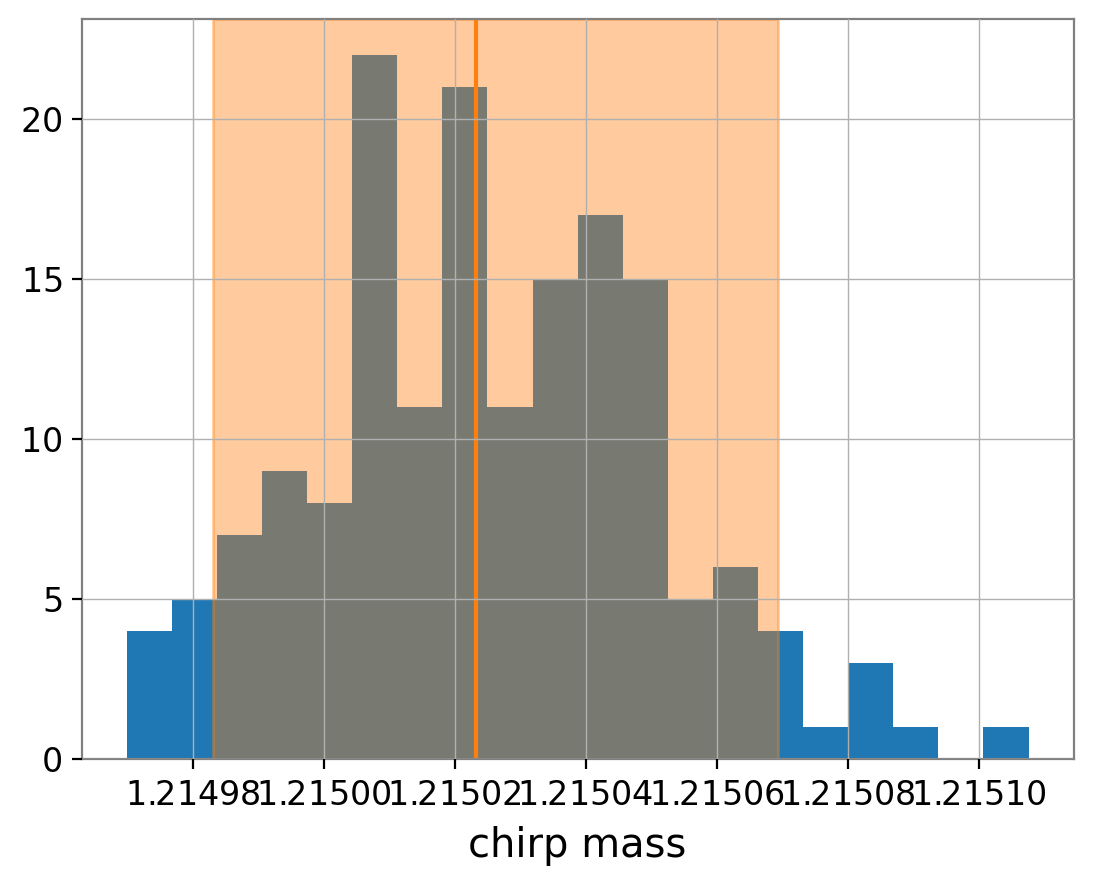

In [ ]:
# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Plot a histogram of the posterior samples for chirp mass with 20 bins
ax.hist(result.posterior["chirp_mass"], bins=20)

# Highlight the 90% confidence interval region with a semi-transparent color
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)

# Draw a vertical line at the median chirp mass value
ax.axvline(median, color='C1')

# Label the x-axis
ax.set_xlabel("chirp mass")

# Display the plot
plt.show()

> Compared to the earlier waveform plot, which showed how well a guess matches the data, this histogram gives a statistical summary of the chirp mass. It shows the probability of many possible values rather than a single waveform match.

### Corner Plot

The **corner plot** below shows the probability distributions of key parameters from the analysis, here the chirp mass and symmetric mass ratio. Think of it as a map of clues, revealing which combinations of values are most likely and how the parameters relate to each other.

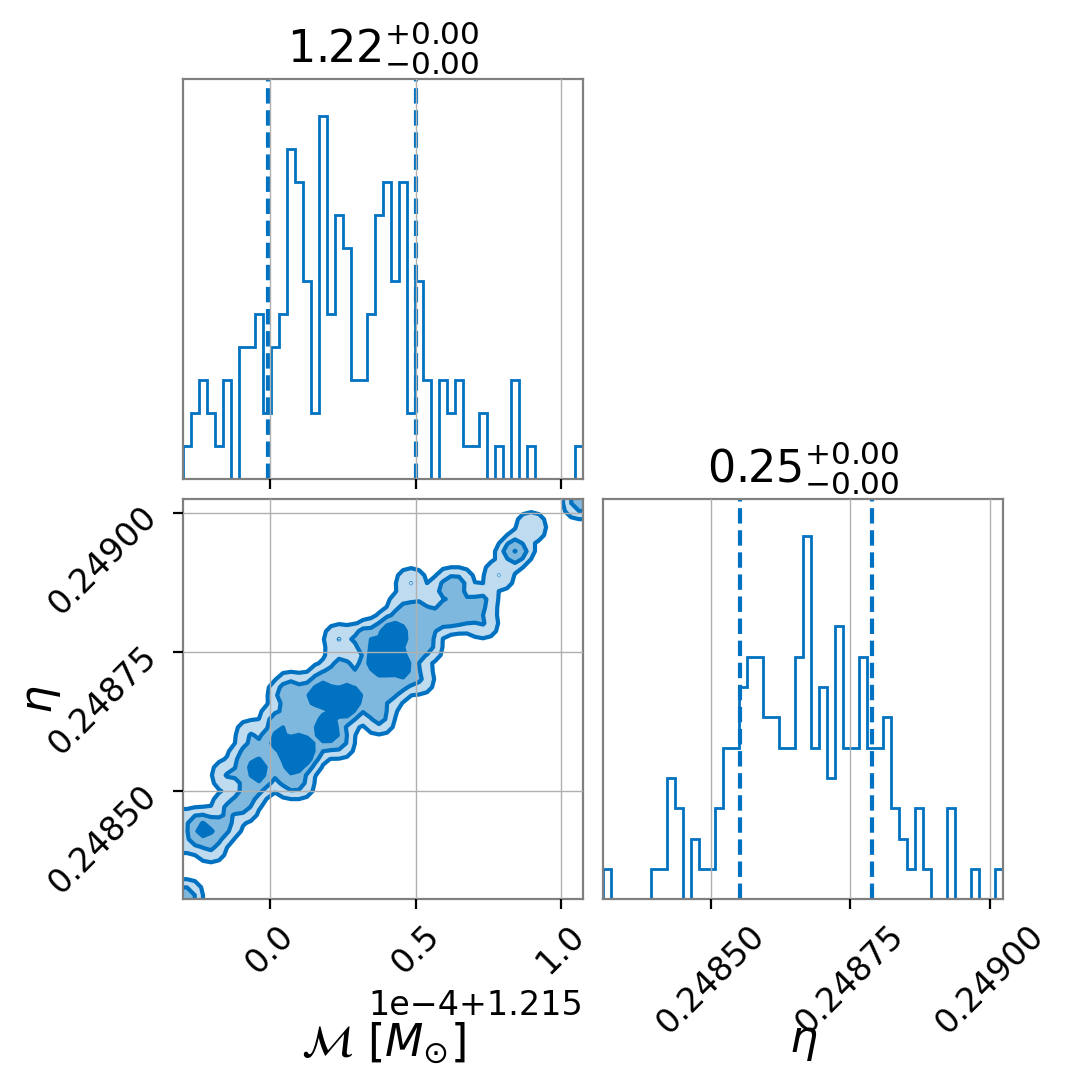

In [ ]:
# Plot a corner (pairwise joint distribution) plot of selected parameters
# Parameters plotted: chirp_mass, mass_ratio, geocent_time, and phase
# Include the prior distributions for comparison by setting prior=True

parameters = ["chirp_mass", "symmetric_mass_ratio"]

truths = [1.22, 0.25]

result.plot_corner(
    parameters=parameters,
    prior=True,
)

- Diagonal plots show the individual distributions for each parameter, revealing which values are most likely after analyzing the data.
- Off-diagonal plots show joint distributions for pairs of parameters, highlighting correlations or likely combinations.

For instance, the chirp mass and symmetric mass ratio are often correlated—knowing one gives clues about the other.

Shaded areas show the prior distributions, our starting guesses. Comparing priors and posteriors shows how the data updated our understanding.

### Calculate the Log Bayes Factor

The **log Bayes factor** tells us how strongly the data supports a real signal versus just noise.

- A large positive value means the signal is very likely real.
- A small or negative value means the data could just be noise.

The error shows our confidence in this number—a smaller error means we can trust the result more.

In [ ]:
# Print the log Bayes factor and its uncertainty (error)
# The Bayes factor measures how strongly the data supports the model compared to noise
print("ln Bayes factor = {} +/- {}".format(
    result.log_bayes_factor, result.log_evidence_err))

ln Bayes factor = 1392.9441676153444 +/- 0.72034765115605


## Interpreting the GW170817 Analysis and Bayes Factor

Our analysis of GW170817 shows how Bayes’ Theorem helps turn noisy data into solid clues about the event. Using prior knowledge and the gravitational-wave signal, we can estimate key properties—like the masses, distance, and orientation of the neutron stars—and know how confident we are in those estimates.

A key number is the log Bayes factor, about **1393 ± 0.7**. This tells us how strongly the data favors a real signal over noise. Such a large value confirms beyond doubt that a genuine event occurred, giving us confidence that our parameter estimates truly reflect the system we observed.


### Multiple Choice Question (MCQ):

What was one of the major scientific breakthroughs achieved from the gravitational wave event GW170817?

A. Discovery of a new class of black holes \
B. First detection of gravitational waves from a binary neutron star merger \
C. First observation of gravitational waves without any electromagnetic counterpart \
D. Detection of dark matter annihilation through gravitational waves

<details>
<summary><strong>Show Answer and Explanation</strong></summary>

Correct Answer: B. First detection of gravitational waves from a binary neutron star merger

Explanation:
GW170817 marked the first time in history that gravitational waves and electromagnetic signals (like gamma rays and visible light) were observed from the same astrophysical event. This neutron star merger allowed scientists to confirm theories about the origin of heavy elements (like gold and platinum), better understand the speed of gravitational waves, and refine the Hubble constant using statistical methods like Bayes’ Theorem. This multi-messenger event was a massive leap forward for astrophysics.

</details>



# Want to dig deeper beyond a single event? Continue to learn about the entire population of Gravitational-Wave mergers observed throughout the Universe so far!

# GWTC-3.0 Confident Parameter Estimation Results


LIGO Scientific Collaboration, Virgo Collaboration, & KAGRA Collaboration. (2024). The population of merging compact binaries inferred using gravitational waves through GWTC-3 - Data release (Version v3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.11254021

> Since the first detection of gravitational waves, dozens of compact binary mergers—primarily binary black holes and neutron star systems—have been observed, revealing a rich population of these cosmic collisions. The latest [Gravitational-Wave Transient Catalog (GWTC-3)](https://arxiv.org/abs/2111.03606), released by the LIGO, Virgo, and KAGRA collaborations, compiles confident parameter estimates for over 90 events, offering detailed insights into the masses, spins, and merger rates of these sources. Analyses of this dataset show intriguing features in the mass distributions, such as distinct peaks and gaps, suggesting complex astrophysical formation channels beyond simple power-law models.

> For a deep dive into these findings, see the key papers by the collaborations, including [Abbott et al. (2021)](https://arxiv.org/abs/2010.14527) on **GWTC-2** and the updated results in [Abbott et al. (2023)](https://arxiv.org/abs/2111.03606) for **GWTC-3**, which provide the foundation for understanding the evolving population of gravitational wave sources.

### Let's remake some of the population figures!

In [ ]:
# Import the normal distribution functions from scipy.stats for statistical modeling
from scipy.stats import norm
# Import basic statistics module for calculating measures like mean, median, etc.
import statistics
# Import curve fitting function to fit models to data
from scipy.optimize import curve_fit
# Import Kernel Density Estimation from sklearn for smooth probability density estimates
from sklearn.neighbors import KernelDensity

# Import astronomical coordinate and distance handling tools from Astropy
from astropy.coordinates import SkyCoord, Distance
# Import units module from Astropy to handle physical units (e.g., parsecs, solar masses)
from astropy import units as u
# Import the Planck15 cosmology model for distance and redshift calculations
from astropy.cosmology import Planck15

# Import matplotlib patches for adding custom legend elements or shapes to plots
import matplotlib.patches as mpatches
# Import pandas for data manipulation and analysis, especially CSV file reading
import pandas as pd

In [ ]:
# Read the CSV file containing the GWTC-3 confident event catalog data into a pandas DataFrame

# Via GitHub
gwtc_url = "https://raw.githubusercontent.com/rlanggin/GW_Explorer_A_Beginners_Guide/main/data/GWTC-3-confident.csv"
gwtc3 = pd.read_csv(gwtc_url)

# Via Google Drive – Make sure to adjust the file path to where your 'GWTC-3-confident.csv' file is located
#gwtc3 = pd.read_csv('/content/drive/My Drive/UNLV/research/projects/GW_Explorer_A_Beginners_Guide/Notebook_Drafts/GWTC-3-confident.csv')

In [ ]:
gwtc3.head()

,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW191103_012549-v1,GW191103_012549,1,GWTC-3-confident,1.256780e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,11.8,-2.2,6.2,...,0.09,0.46000,NaN,NaN,0.94318,NaN,NaN,19.0,-1.7,3.8
1,GW191105_143521-v1,GW191105_143521,1,GWTC-3-confident,1.257000e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,10.7,-1.6,3.7,...,0.07,0.01200,NaN,NaN,0.99000,NaN,NaN,17.6,-1.2,2.1
2,GW191109_010717-v1,GW191109_010717,1,GWTC-3-confident,1.257297e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,65.0,-11.0,11.0,...,0.18,0.00018,NaN,NaN,0.99000,NaN,NaN,107.0,-15.0,18.0
3,GW191113_071753-v1,GW191113_071753,1,GWTC-3-confident,1.257665e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,29.0,-14.0,12.0,...,0.18,26.00000,NaN,NaN,0.68339,NaN,NaN,34.0,-10.0,11.0
4,GW191126_115259-v1,GW191126_115259,1,GWTC-3-confident,1.258804e+09,/GWTC-3/,http://gwosc.org/eventapi/json/GWTC-3-confiden...,12.1,-2.2,5.5,...,0.12,3.20000,NaN,NaN,0.70041,NaN,NaN,19.6,-2.0,3.5


In [ ]:
# Column options (see explanation below):
print(gwtc3.keys())

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro',
       'p_astro_lower', 'p_astro_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')


<details>
<summary><strong>Explanation of Each Parameter:</strong></summary>

1.	id
→ The official name of the gravitational wave event.
Format: GW[YYMMDD]_[Time], e.g., GW191103_012549.

2.	commonName → A shorter, more familiar name for the event, often just omitting the version suffix (e.g., -v1).

3.	version
→ The version number of this event’s data. This shows whether it’s the first release (1) or a later update.

4.	catalog.shortName
→ Identifies which catalog the event comes from. For example, GWTC-3-confident means it comes from the third Gravitational Wave Transient Catalog and is confidently classified.

5.	GPS
→ The Global Positioning System time (in seconds since January 6, 1980) when the event occurred.

6.	reference
→ A path pointing to the event’s data or associated paper within the GWOSC data structure.

7.	jsonurl
→ A direct link to the JSON metadata file for the event, hosted on GWOSC, containing detailed parameters.

8.	mass_1_source
→ The estimated source-frame mass (in solar masses) of the primary (more massive) compact object (e.g., black hole or neutron star) before merging.

9.	mass_1_source_lower
→ The lower bound (uncertainty) on the primary mass.

10.	mass_1_source_upper
→ The upper bound (uncertainty) on the primary mass.

⸻

Skipping repeated structure for brevity, but know that other parameters like mass_2_source, chirp_mass, luminosity_distance, etc., follow a similar naming pattern with _lower and _upper bounds for uncertainties.

⸻

11.	redshift_upper
→ The upper uncertainty on the estimated redshift of the event (how much the signal is stretched due to cosmic expansion).

12.	far
→ False Alarm Rate – how often a similar event could have occurred just from random detector noise. Lower is better (i.e., more confident detection).

13.	far_lower / far_upper
→ Lower and upper estimates for the false alarm rate (sometimes NaN if not available).

14.	p_astro
→ The astrophysical probability that this signal is from a true astrophysical source rather than noise. Values close to 1 mean high confidence.

15.	p_astro_lower / p_astro_upper
→ The uncertainties associated with that astrophysical probability.

16.	final_mass_source
→ Estimated mass of the final object formed after the merger (e.g., a black hole).

17.	final_mass_source_lower
→ The lower uncertainty of that final mass.

18.	final_mass_source_upper
→ The upper uncertainty of that final mass.


19. total_mass_source
→ Total mass of the system in the source frame.

20. total_mass_source_lower / total_mass_source_upper
→ Uncertainty range for the total mass in the source frame.

21. chirp_mass_source
→ “Chirp mass” of the system, a key parameter affecting gravitational wave frequency evolution.

22. chirp_mass_source_lower / chirp_mass_source_upper
→ Uncertainty range for the chirp mass.

23. mass_ratio
→ Ratio of the lighter mass to the heavier mass in the binary (q = m2/m1, where m2 ≤ m1).

24. mass_ratio_lower / mass_ratio_upper
→ Uncertainty range for the mass ratio.

25. chi_eff
→ Effective spin aligned with the orbital angular momentum (influences inspiral rate).

26. chi_eff_lower / chi_eff_upper
→ Uncertainty range for the effective spin.

27. chi_p
→ Effective precession spin parameter (captures spin-induced orbital precession).

28. chi_p_lower / chi_p_upper
→ Uncertainty range for precession spin.

29. luminosity_distance
→ Distance to the gravitational wave source in megaparsecs (Mpc).

30. luminosity_distance_lower / luminosity_distance_upper
→ Uncertainty range for the luminosity distance.

31. redshift
→ Cosmological redshift caused by the expansion of the universe.

32. redshift_lower / redshift_upper
→ Uncertainty range for the redshift value.

33. cos_theta_jn
→ Cosine of the angle between the total angular momentum and the line of sight.

34. cos_theta_jn_lower / cos_theta_jn_upper
→ Uncertainty range for the orientation angle.

35. network_matched_filter_snr
→ Signal-to-noise ratio from matched filtering across the detector network.

36. network_optimal_snr
→ The optimal (maximum possible) SNR achievable given the data.

37. p_astro
→ Probability that the event is of astrophysical origin.

38. has_remnant_mass_gap
→ Indicates if the final object’s mass lies in the “mass gap” (between neutron stars and black holes).

39. has_mass_gap
→ Indicates if either component lies in the mass gap.

40. has_ns
→ True if at least one object is consistent with a neutron star.

41. has_remnant
→ True if the event likely resulted in a remnant object (like a black hole).

42. version
→ Data release version this event belongs to (e.g., O3b).

</details>


In [ ]:
gwtc3['redshift'].max() # Maximum redshift (distance light has traveled) from the population

dist1 = Distance(unit=u.pc, z = gwtc3['redshift'].max(), cosmology = Planck15) # Turn this redshift into distance using astropy

print(dist1/1000000) # Distance / One Million to convert from Megaparsecs to parsecs

7128.328068765086 pc


In [ ]:
print(max(gwtc3['mass_1_source'])) # Maximum primary source mass from the population in solar masses

87.0


In [ ]:
print(np.std(gwtc3['mass_1_source'])) # Standard deviation of the primary source mass

17.921460399675656


Now that we’ve converted redshift into distance and explored some basic statistical parameters like the standard deviation of mass, we can start to examine how this population of black holes is distributed across different masses.

To get a clearer statistical view of the data, it’s helpful to begin with a simple histogram of the **primary source mass** $(m_1$), like we saw with the chirp mass histogram above.


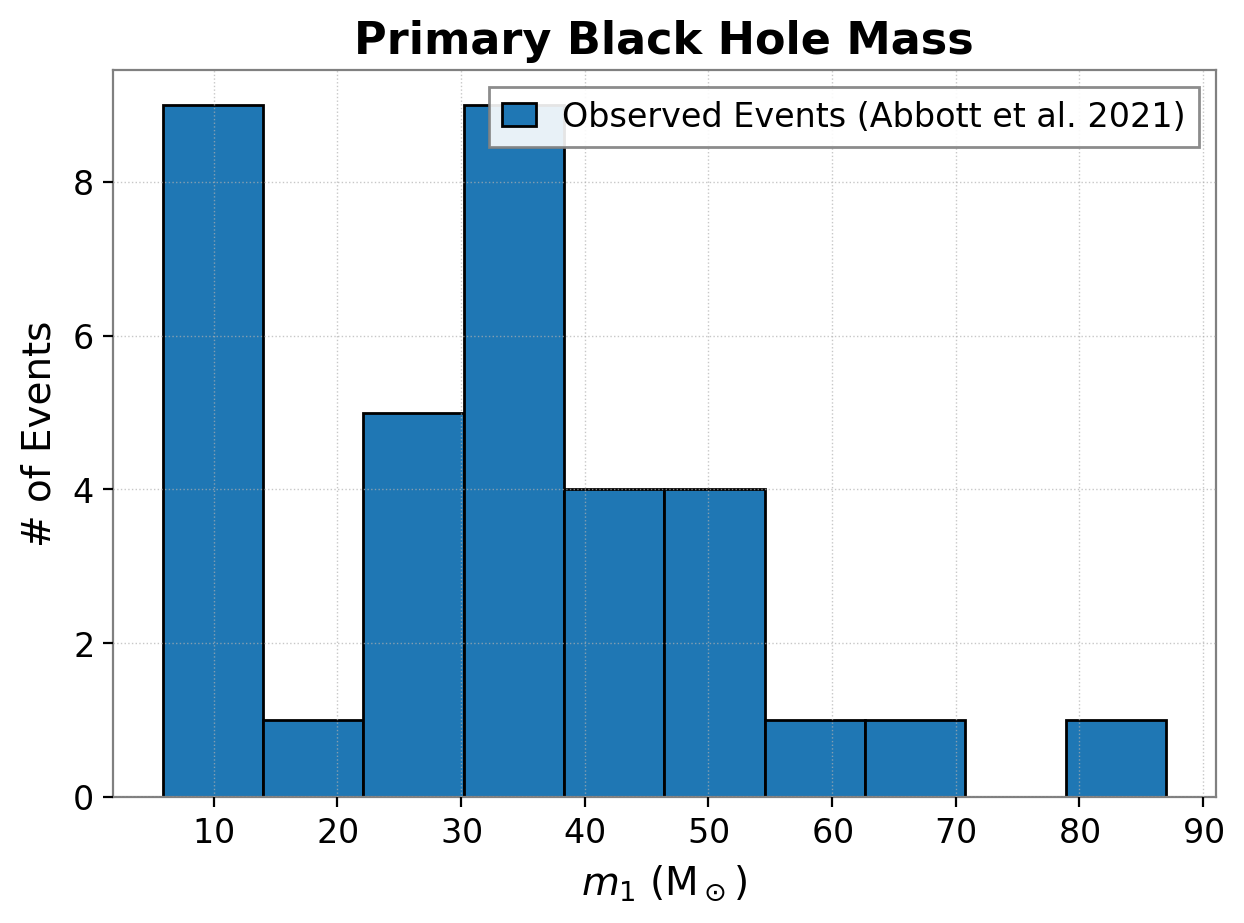

In [ ]:
# Histogram plot of primary mass
plt.hist(gwtc3['mass_1_source'], label='Observed Events (Abbott et al. 2021)', edgecolor='black')

plt.xlabel(r'$m_1$ (M$_\odot$)', fontsize=14)
plt.ylabel(r'# of Events', fontsize=14)
plt.title('Primary Black Hole Mass', fontsize=16, fontweight='bold')

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()

> By analyzing the histogram, we gain an intuitive sense of the population’s overall shape and where the majority of black hole masses lie, which sets the foundation for more detailed population studies like the evolution of primary mass with redshift.

Building on the histogram, we now want to understand how the rate of black hole mergers depends on the primary mass, not just in terms of raw counts, but normalized by the volume of the universe and the time over which these events occur.

This leads us to examine the **merger rate density** as a function of the primary mass $(m_1$), measured in units of:

- Number of mergers per cubic gigaparsec (Gpc$^3$) of cosmic volume,  
- Per year (time),  
- Per unit solar mass ($M_\odot$) of the primary black hole.

By studying the merger rate density, we get a physically meaningful picture of how common mergers of different masses are throughout the observable universe.

Fitting a **power law** to this distribution is important because many astrophysical processes naturally produce populations that follow power-law behaviors. This helps us quantify the underlying physics governing black hole formation and growth. Deviations from a simple power law—like peaks or cutoffs—can reveal new astrophysical phenomena or the influence of different formation channels.


<>:42: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-2432014983.py:42: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('m$_1$ (M$_\odot$)')
/tmp/ipython-input-2432014983.py:8: RuntimeWarning: invalid value encountered in power
  return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))
/tmp/ipython-input-2432014983.py:8: RuntimeWarning: invalid value encountered in scalar power
  return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))


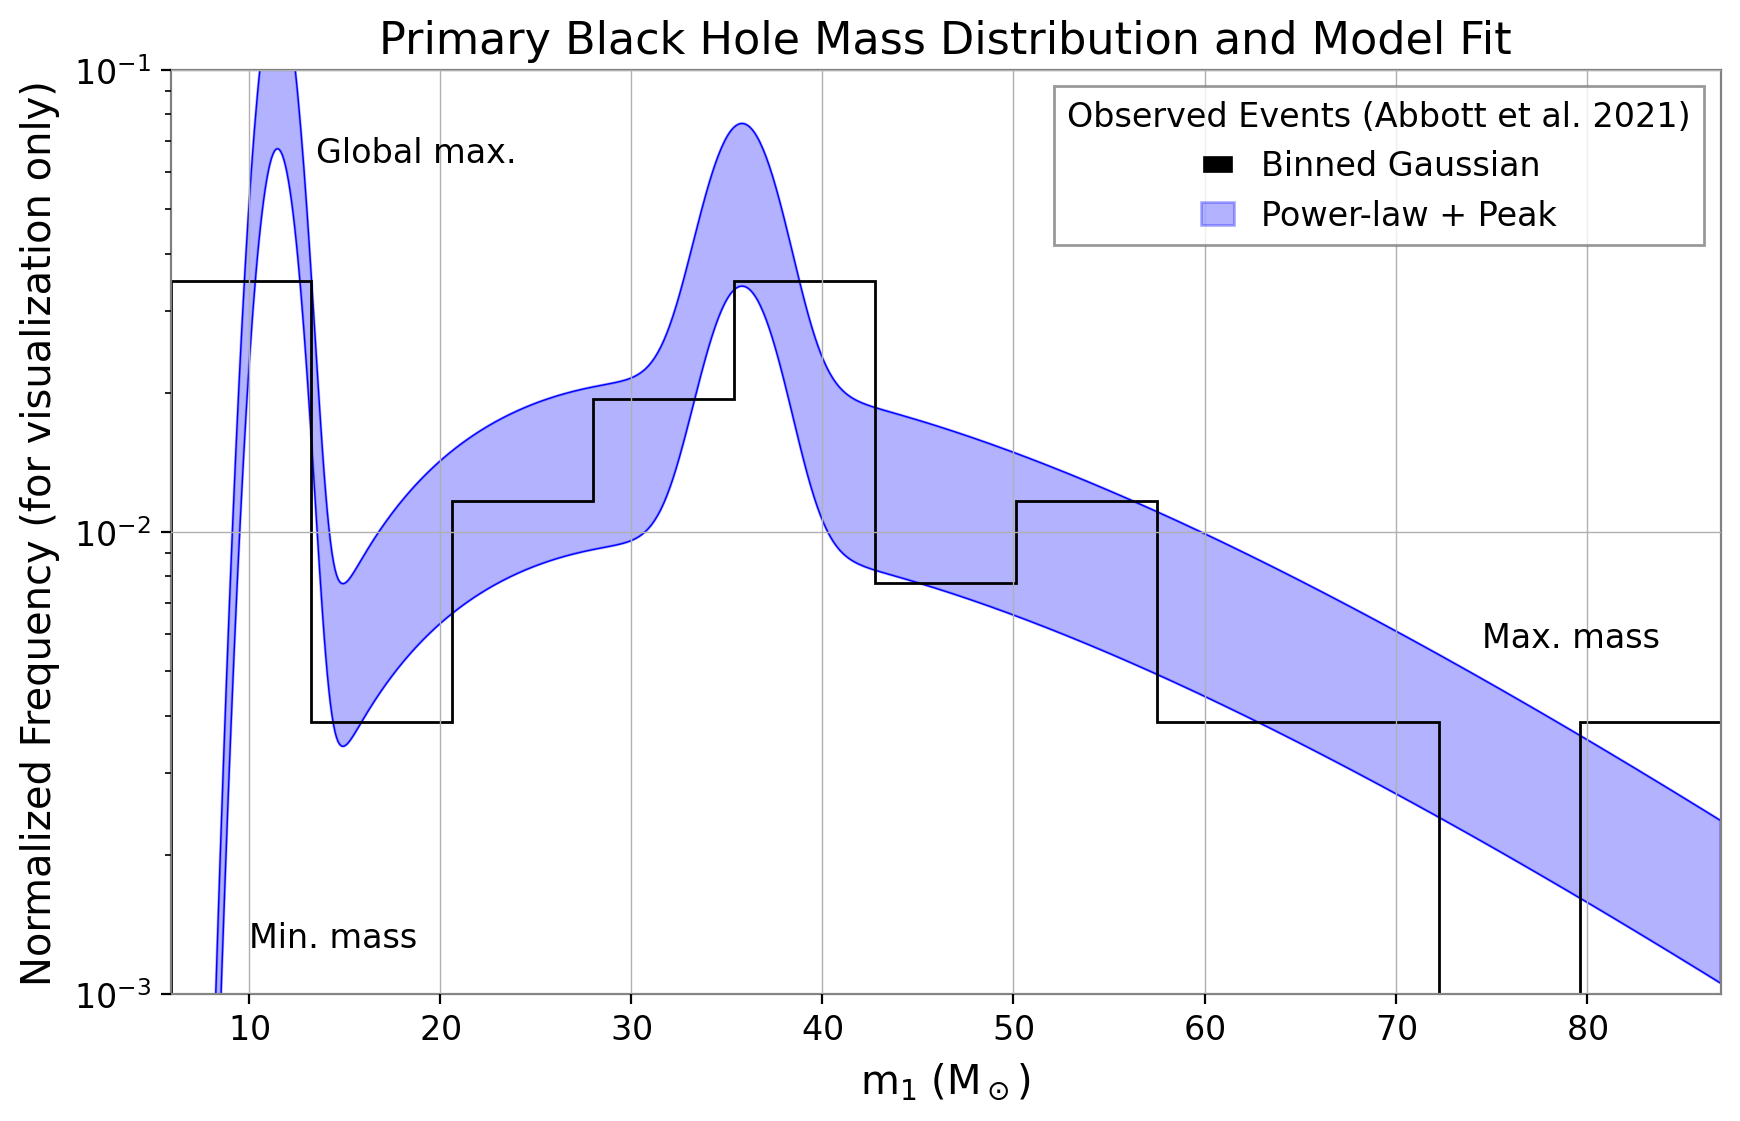

In [ ]:
plt.figure(figsize=(10,6))
# Create a histogram to get the frequencies and bin edges
counts, bins = np.histogram(gwtc3['mass_1_source'], bins=30, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define the power law function
def power_law(x, alpha, a, xmin, xmax, smoothing):
    return a * ((x - xmin) / (xmax - xmin))**alpha * np.exp(-smoothing * (x - xmin))

# Define the Gaussian peak function
def gaussian_peak(x, a1, mu1, sigma1):
    return a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))

# Define the combined model: smoothed power law + double Gaussian peak
def combined_model(x, alpha, a, xmin, xmax, smoothing, a1, mu1, sigma1, a2, mu2, sigma2):
    return power_law(x, alpha, a, xmin, xmax, smoothing) + gaussian_peak(x, a1, mu1, sigma1) + gaussian_peak(x, a2, mu2, sigma2)

# Initial guess for the parameters (slope, amplitude, min mass, max mass, smoothing, Gaussian amplitude 1, Gaussian mean 1, Gaussian standard deviation 1, Gaussian amplitude 2, Gaussian mean 2, Gaussian standard deviation 2)
initial_guess = [1, 1, 5.9, 87.0, 0.1, 0.02, 8, 3, 0.03, 38, 5]

# Fit the combined model to the data
params, covariance = curve_fit(combined_model, bin_centers, counts, p0=initial_guess, maxfev = 150000)

# Generate points for the smoothed line representing the fit
x_fit = np.linspace(min(gwtc3['mass_1_source']), max(gwtc3['mass_1_source']), 1000)
y_fit = combined_model(x_fit, *params)

# Calculate the standard deviation at each point along the fitted curve
sigma_band = np.zeros_like(y_fit)
for i in range(len(x_fit)):
    sigma_band[i] = np.sqrt(np.sum((combined_model(x_fit[i], *params) - y_fit[i])**2))

# Plotting the shaded band
plt.plot(x_fit, 1.5*(y_fit + sigma_band), c='b', linewidth=0.5)
plt.plot(x_fit, (y_fit - sigma_band)/1.5, c='b', linewidth=0.5)
#plt.plot(x_fit, y_fit, c='b', linestyle='--', lw=1)
plt.fill_between(x_fit, (y_fit - sigma_band)/1.5, 1.5*(y_fit + sigma_band), edgecolor=(1,0,0,1), color='b', alpha = 0.3, linewidth=1)

plt.hist(gwtc3['mass_1_source'], bins=11, density=True, histtype=u'step', color='black')

# Adding labels, title, and legend
plt.xlabel('m$_1$ (M$_\odot$)')
plt.ylabel('Normalized Frequency (for visualization only)')
plt.yscale('log')
plt.xlim(5.9,87.0)
plt.ylim(1e-3, 1e-1)
red_patch = mpatches.Patch(color='blue', label='Power-law + Peak', alpha=0.3)
black_line = plt.Line2D([0], [0], color='black', lw=1, label='Binned Gaussian')
plt.title('Primary Black Hole Mass Distribution and Model Fit', fontsize=16)
plt.legend()
plt.legend(handles=[black_line,red_patch], title='Observed Events (Abbott et al. 2021)')

#adding text inside the plot
plt.text(13.5, 10**-1.2, 'Global max.', fontsize = 12)
plt.text(10, 10**-2.9, 'Min. mass', fontsize = 12)
plt.text(74.5, 10**-2.25, 'Max. mass', fontsize = 12)


# Displaying the plot
# plt.savefig('./GWTC-3_MD.pdf', bbox_inches='tight')
plt.show()

The plot above shows the distribution of black hole masses detected through gravitational waves. Each bar is a clue — taller bars mean more common masses, shorter bars mean rarer ones. But we don’t have all the clues: some black holes are too far away or too quiet for our detectors to notice. How long we observe and which parts of the universe we can see also affect what shows up; these are called selection effects, survey time, and volume limitations.

The y-axis shows normalized frequency, meaning how often each mass appears in the data, not the actual number of black holes. The log scale helps us see both common and rare masses.

While this notebook only shows the clues we have, real astrophysicists combine them with other data to uncover patterns in black hole formation and evolution — the bigger investigation happening behind the scenes.

**Key terms:**
- Mass ($M_\odot$): the mass of the primary black hole in each binary.
- Normalized frequency: how many events appear at each mass range, scaled for easy comparison.

This plot helps us explore patterns in black hole populations, like which masses are most typical. By comparing the average values from multiple parameters—such as mass vs. spin or mass ratio vs. redshift—we can start investigating trends in how black holes form and evolve.

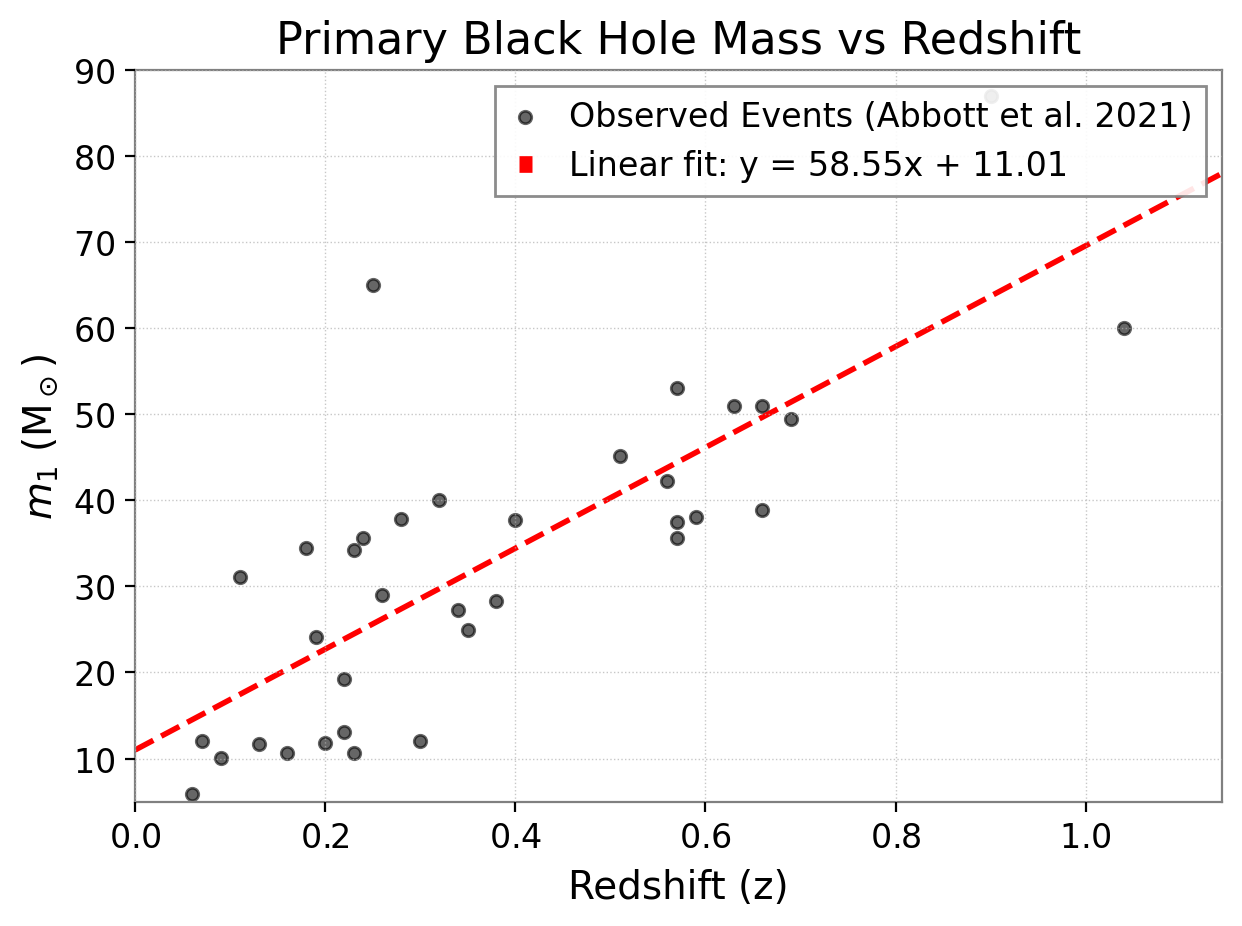

In [ ]:
# Scatter plot of primary mass vs redshift
plt.scatter(gwtc3['redshift'], gwtc3['mass_1_source'], color='black', alpha=0.6, s=20,
            label='Observed Events (Abbott et al. 2021)')

# Compute linear fit
slope, intercept = np.polyfit(gwtc3['redshift'], gwtc3['mass_1_source'], 1)
x_vals = np.linspace(0, max(gwtc3['redshift']) * 1.1, 100)
y_vals = slope * x_vals + intercept

# Plot linear fit line
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2,
         label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}')

# Add axis labels and title
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel(r'$m_1$ (M$_\odot$)', fontsize=14)
plt.title('Primary Black Hole Mass vs Redshift', fontsize=16)

# Set axis limits for better visualization
plt.xlim(0, max(gwtc3['redshift']) * 1.1)
plt.ylim(5, 90)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()

This scatter plot shows observed binary black hole mergers, with each average **primary mass ($m_1$)** on the vertical axis and the average redshift (z) on the horizontal axis.

Each point represents an event from the GWTC-3 catalog.
- Higher masses tend to appear at larger redshifts because heavier black holes produce stronger signals that are easier to detect at greater distances.
- Lighter black holes are mostly observed nearby (low redshift) due to detection limits.
- This trend reflects observational bias rather than a direct physical correlation.

>Important note: In this simple, toy analysis, we ignore selection effects and only use the average values for each event. This means the trends we see should be taken with caution — they are not precise measurements of the true population. Still, this approach allows us to see some overall patterns and get an intuitive sense of how black hole mass and redshift are related.

Understanding these limitations helps scientists design more detailed analyses that correct for bias and study black hole populations across cosmic history.

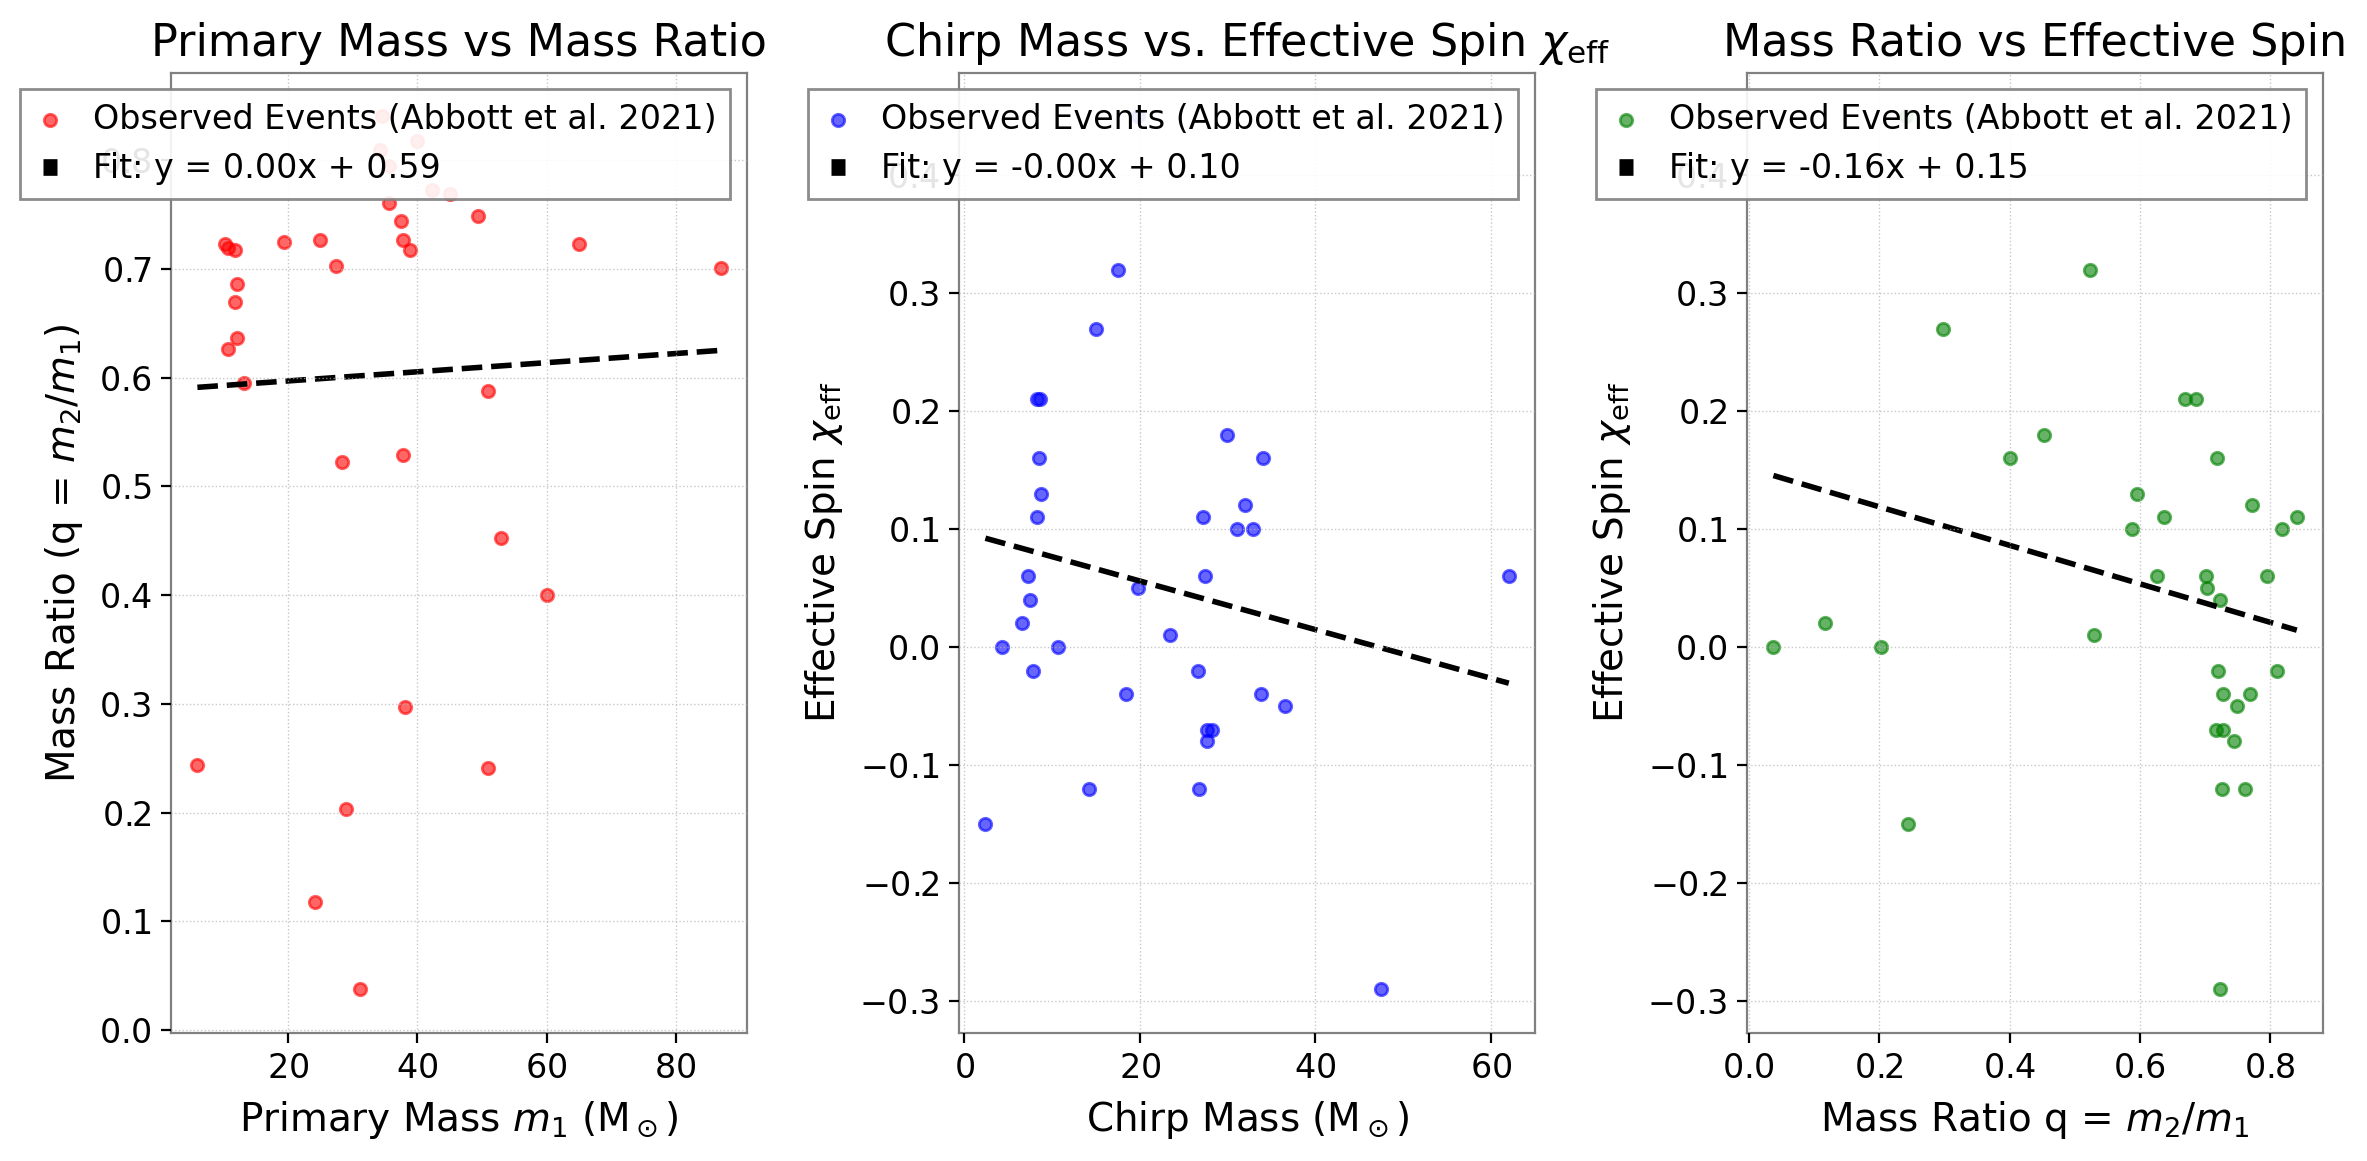

In [ ]:
mass_ratio = gwtc3['mass_2_source'] / gwtc3['mass_1_source']

# Create a 1x3 subplot figure
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Left subplot: Primary Mass vs Mass Ratio
axs[0].scatter(gwtc3['mass_1_source'], mass_ratio, color='red', alpha=0.6, s=20,
               label='Observed Events (Abbott et al. 2021)')

# Linear fit
slope1, intercept1 = np.polyfit(gwtc3['mass_1_source'], mass_ratio, 1)
x_vals1 = np.linspace(min(gwtc3['mass_1_source']), max(gwtc3['mass_1_source']), 100)
y_vals1 = slope1 * x_vals1 + intercept1
axs[0].plot(x_vals1, y_vals1, color='black', linestyle='--', linewidth=2,
            label=f'Fit: y = {slope1:.2f}x + {intercept1:.2f}')

axs[0].set_xlabel(r'Primary Mass $m_1$ (M$_\odot$)', fontsize=14)
axs[0].set_ylabel('Mass Ratio (q = $m_2 / m_1$)', fontsize=14)
axs[0].set_title('Primary Mass vs Mass Ratio', fontsize=16)
axs[0].grid(True, linestyle=':', alpha=0.7)
axs[0].legend(fontsize=12, framealpha=0.9, loc='upper right')

# Middle subplot: Effective Spin vs Chirp Mass
axs[1].scatter(gwtc3['chirp_mass_source'], gwtc3['chi_eff'], color='blue', alpha=0.6, s=20,
               label='Observed Events (Abbott et al. 2021)')

# Linear fit
slope2, intercept2 = np.polyfit(gwtc3['chirp_mass_source'], gwtc3['chi_eff'], 1)
x_vals2 = np.linspace(min(gwtc3['chirp_mass_source']), max(gwtc3['chirp_mass_source']), 100)
y_vals2 = slope2 * x_vals2 + intercept2
axs[1].plot(x_vals2, y_vals2, color='black', linestyle='--', linewidth=2,
            label=f'Fit: y = {slope2:.2f}x + {intercept2:.2f}')

axs[1].set_xlabel(r'Chirp Mass (M$_\odot$)', fontsize=14)
axs[1].set_ylabel(r'Effective Spin $\chi_{\mathrm{eff}}$', fontsize=14)
axs[1].set_title(r'Chirp Mass vs. Effective Spin $\chi_{\mathrm{eff}}$', fontsize=16)
axs[1].grid(True, linestyle=':', alpha=0.7)
axs[1].legend(fontsize=12, framealpha=0.9, loc='upper right')

# Right subplot: Mass Ratio vs Effective Spin
axs[2].scatter(mass_ratio, gwtc3['chi_eff'], color='green', alpha=0.6, s=20,
               label='Observed Events (Abbott et al. 2021)')

# Linear fit
slope3, intercept3 = np.polyfit(mass_ratio, gwtc3['chi_eff'], 1)
x_vals3 = np.linspace(min(mass_ratio), max(mass_ratio), 100)
y_vals3 = slope3 * x_vals3 + intercept3
axs[2].plot(x_vals3, y_vals3, color='black', linestyle='--', linewidth=2,
            label=f'Fit: y = {slope3:.2f}x + {intercept3:.2f}')

axs[2].set_xlabel('Mass Ratio q = $m_2 / m_1$', fontsize=14)
axs[2].set_ylabel(r'Effective Spin $\chi_{\mathrm{eff}}$', fontsize=14)
axs[2].set_title('Mass Ratio vs Effective Spin', fontsize=16)
axs[2].grid(True, linestyle=':', alpha=0.7)
axs[2].legend(fontsize=12, framealpha=0.9, loc='upper right')

plt.tight_layout()
plt.show()


These two scatter plots show important relationships in observed binary black hole mergers from GWTC-3:

- **Primary mass vs mass ratio (left):**  
  Displays how the primary black hole mass $(m_1$) relates to the mass ratio($q = \frac{m_2}{m_1}$). Points near $(q=1$) indicate nearly equal-mass binaries, which are common in isolated binary evolution.

- **Chirp Mass vs Effective spin(right):**  
  Shows the chirp mass against effective spin $(\chi_{\mathrm{eff}})$, illustrating spin alignment relative to the orbital plane. More massive binaries tend to have a wider spread in effective spin.

- The correlation of high mass ratios with aligned spins $(\chi_{\mathrm{eff}} \sim 0$) supports the idea that equal-mass binaries often form through isolated evolution, while more varied spins and mass ratios suggest dynamical formation channels.


## Investigating Black Hole Populations
With all the events we’ve observed, we can start looking at the population as a whole instead of just individual mergers. By analyzing many detected black holes, we can start building simple astrophysical models:

- Which masses are most common?
- How do mass ratios and spins relate?
- Are there trends that hint at how these binaries formed?
- These plots give us a first, statistical look at these questions:
- Primary mass vs mass ratio – shows the spread of mass combinations.
- Chirp mass vs effective spin – shows how the total mass relates to aligned spins.
- Mass ratio vs effective spin – shows the decreasing trend for aligned spins at high mass ratios.
> Caveat: This is a toy analysis. We’re using only observed averages and ignoring selection effects like detector sensitivity, survey volume, and observational biases. So while we can see overall trends, we shouldn’t overinterpret the exact numbers. This would require a more careful setup (see [GWTC-4.0: Population Properties of Merging Compact Binaries](https://arxiv.org/abs/2508.18083)).

Our setup and analysis introduces how astrophysicists study populations statistically while keeping it accessible for students, and the plots are perfect visual clues for this investigation.

# You’ve Engaged with Real Science

Throughout this journey, you’ve explored some of the most fascinating aspects of our universe—space, time, and gravity—not just as abstract ideas, but as tangible phenomena that scientists study every day.

You’ve learned that gravity is more than just a force pulling objects together. It’s actually the shape and bending of spacetime itself. This understanding allows us to detect ripples in the fabric of the universe called gravitational waves.

These waves come from some of the most extreme and mysterious events in the cosmos: collisions between massive objects like black holes and neutron stars, which are invisible to ordinary telescopes. By detecting and analyzing these signals, we can "listen" to the universe in a completely new way.

But more than just understanding what gravitational waves are, you’ve learned how to *interpret* the data they carry. This skill is at the heart of modern astrophysics. The tools and methods you’ve worked with here are the same ones scientists use to make groundbreaking discoveries today.

With this foundation, you’re equipped to:  

- Dive into actual astrophysical data and explore recent gravitational-wave detections  
- Investigate how these cosmic events teach us about the universe’s most extreme objects  
- Build your own visualizations and models to better understand and communicate these discoveries  
- Inspire others by showing that science is a process of exploration and continuous learning, not just a set of facts  

> The universe sends messages through ripples in spacetime.  

> Now, you have the tools to decode those messages.

---

Thank you for taking the time to explore these concepts. Remember, science is a journey—one fueled by curiosity, critical thinking, and a willingness to question and discover. Keep asking questions, keep exploring, and never stop looking up.

---

## Want to Explore Further?

If you want to continue your journey, check out the full dataset of gravitational-wave detections at [GWOSC.org](https://www.gw-openscience.org). You can find more tutorials at [GWOSC.org/tutorials](https://gwosc.org/tutorials/) and annual workshops at [GWOSC.org/workshops](https://gwosc.org/workshops/). For those interested in digging deeper, tools like [PyCBC](https://pycbc.org/) and [Bilby](https://bilby-dev.github.io/bilby/) offer access to waveform modeling and advanced data analysis pipelines.

---